# Training a Siamese model on MNIST dataset using PyTorch and self-supervised learning

In [1]:
# !pip install git+https://github.com/ziadloo/Siamese-model-in-Pytorch.git

In [2]:
import torch
from torch import nn
import torchvision
import random
import copy
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
import plotly.graph_objs as go
import glob
from PIL import Image
import sys
import os
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from IPython import display
from matplotlib.ticker import MaxNLocator
from TheOneLRScheduler import TheOneLRScheduler
import multiprocessing as mp
import chevron
import resource
import tabulate
import math
from kmeans_pytorch import kmeans
import itertools


rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2048, rlimit[1]))
torch.multiprocessing.set_sharing_strategy('file_system')


# Add the path of the parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# Now you can perform relative imports
from Siamese import SiameseDataLoader, SiameseDataset, SiameseModel, triplet_loss, info_nce_loss

torch.manual_seed(42)
random.seed(42)

In [3]:
class_count = 10
latent_size = 3
batch_size_cls = 100
batch_size_sl = 400
batch_size_ssl = 400

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Model design

In [5]:
class MnistCnn(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.projector = nn.Sequential(
            nn.Linear(32 * 8 * 8, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, latent_size)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.projector(x)
        return x


class DownstreamMnistCnn(MnistCnn):
    def __init__(self, base_model, output_size, device):
        super().__init__(output_size)
        for layer in ["cnn"]:
            getattr(self, layer).load_state_dict(getattr(base_model, layer).state_dict())
            for param in getattr(self, layer).parameters():
                param.requires_grad = False
        self.to(device)


class DownstreamMnistCnnExt(MnistCnn):
    def __init__(self, base_model, latent_size, output_size, device):
        super().__init__(latent_size)
        for layer in ["cnn", "projector"]:
            getattr(self, layer).load_state_dict(getattr(base_model, layer).state_dict())
            for param in getattr(self, layer).parameters():
                param.requires_grad = False
        self.ext = nn.Sequential(
            nn.Linear(latent_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, output_size),
        )
        self.to(device)

    def forward(self, x):
        x = super().forward(x)
        return self.ext(x)


class MnistCnnkNN(nn.Module):
    def __init__(self, base_model, data_loader, neighbourhood_size, device):
        super().__init__()
        self.base_model = base_model.to(device)
        self.neighbourhood_size = neighbourhood_size
        embedding_list = []
        target_list = []
        with torch.no_grad():
            for (inputs, targets) in data_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = self.base_model(inputs)
                embedding_list.append(outputs)
                target_list.append(targets)
        embeddings = torch.cat(embedding_list, dim=0)
        self.neighbours = torch.nn.functional.normalize(embeddings, dim=0)
        self.neighbour_labels = torch.cat(target_list, dim=0)

    def forward(self, x):
        with torch.no_grad():
            embeddings = self.base_model(x)
            embeddings = torch.nn.functional.normalize(embeddings, dim=0)
            distances = torch.matmul(embeddings, self.neighbours.T)
        top_values, top_indices = torch.topk(distances, self.neighbourhood_size, dim=1)
        return self.neighbour_labels[top_indices].mode(dim=1).values


class MnistCnnWeightedkNN(nn.Module):
    def __init__(self, base_model, data_loader, neighbourhood_size, device):
        super().__init__()
        self.base_model = base_model.to(device)
        self.neighbourhood_size = neighbourhood_size
        embedding_list = []
        target_list = []
        with torch.no_grad():
            for (inputs, targets) in data_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = self.base_model(inputs)
                embedding_list.append(outputs)
                target_list.append(targets)
        embeddings = torch.cat(embedding_list, dim=0)
        self.neighbours = torch.nn.functional.normalize(embeddings, dim=0)
        self.neighbour_labels = torch.cat(target_list, dim=0)

    def forward(self, x):
        with torch.no_grad():
            embeddings = self.base_model(x)
            embeddings = torch.nn.functional.normalize(embeddings, dim=0)
            distances = torch.matmul(embeddings, self.neighbours.T)
        top_values, top_indices = torch.topk(distances, self.neighbourhood_size, dim=1)
        top_values = (top_values + 1.0) / 2.0
        total_weights = torch.zeros((x.shape[0], 10), dtype=torch.float32, device=x.device)
        total_weights.scatter_add_(1, self.neighbour_labels[top_indices], top_values)
        return torch.argmax(total_weights, dim=1)


class MnistCnnkNNMlp(nn.Module):
    def __init__(self, base_model, data_loader, neighbourhood_size, latent_size, output_size, device):
        super().__init__()
        self.base_model = base_model.to(device)
        self.output_size = output_size
        self.neighbourhood_size = neighbourhood_size
        embedding_list = []
        target_list = []
        with torch.no_grad():
            for (inputs, targets) in data_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = self.base_model(inputs)
                embedding_list.append(outputs)
                target_list.append(targets)
        embeddings = torch.cat(embedding_list, dim=0)
        self.neighbours = torch.nn.functional.normalize(embeddings, dim=0)
        self.neighbour_labels = torch.cat(target_list, dim=0)
        self.projector = nn.Sequential(
            nn.Linear(output_size+latent_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, output_size),
        ).to(device)

    def forward(self, x):
        with torch.no_grad():
            embeddings = self.base_model(x)
            embeddings = torch.nn.functional.normalize(embeddings, dim=0)
            distances = torch.matmul(embeddings, self.neighbours.T)
        top_values, top_indices = torch.topk(distances, self.neighbourhood_size, dim=1)
        neighbour_labels = self.neighbour_labels[top_indices]
        batch_size, n = neighbour_labels.shape
        num_classes = self.output_size  # integer range from 0 to 9
        frequencies = torch.zeros((batch_size, num_classes), dtype=torch.float32, device=neighbour_labels.device)
        for i in range(num_classes):
            frequencies[:, i] = (neighbour_labels == i).sum(dim=1) / self.output_size
        r = torch.cat([frequencies, embeddings], dim=-1)
        return self.projector(r)

In [6]:
# Tower model
model = MnistCnn(latent_size)
print(model)
print("Total number of parameters: ", sum(p.numel() for p in model.parameters()))
print("Total number of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

MnistCnn(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (projector): Sequential(
    (0): Linear(in_features=2048, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)
Total number of parameters:  71651
Total number of trainable parameters:  71651


# Handy classes and functions

In [7]:
class Plots:
    def __init__(self, charts, title=None, log_x=False, log_y=False, x_axis_title="Epoch", y_axis_title=""):
        self.fig, self.ax = plt.subplots(1, 1)
        self.fig.set_size_inches(12, 6, forward=True)
        if title is not None:
            self.fig.suptitle(title, fontsize=16)

        self.hdisplay = display.display("", display_id=True)

        self.ax.set_xlabel(x_axis_title)
        self.ax.set_ylabel(y_axis_title)
        self.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        if log_y:
            self.ax.set_yscale('log')
        if log_x:
            self.ax.set_xscale('log')
        self.log_x = log_x
        self.log_y = log_y

        self.charts = {name: {"color": color, "x": [], "y": []} for name, color in charts.items()}

    def plot(self):
        if self.ax.lines:
            x_min = 1000000
            x_max = 0
            y_min = sys.float_info.max
            y_max = sys.float_info.min
            for i, (label, props) in enumerate(self.charts.items()):
                self.ax.lines[i].set_xdata(props["x"])
                self.ax.lines[i].set_ydata(props["y"])
                if len(props["x"]) > 0:
                    x_min = min(x_min, *props["x"])
                    x_max = max(x_max, *props["x"])
                if len(props["y"]) > 0:
                    y_min = min(y_min, *props["y"])
                    y_max = max(y_max, *props["y"])

            if x_min == x_max:
                x_max += 1
            if y_min == y_max:
                y_max += sys.float_info.epsilon

            if not self.log_x:
                x_min, x_max = self.exapnd(x_min, x_max)
            if not self.log_y:
                y_min, y_max = self.exapnd(y_min, y_max)
            self.ax.set_xlim(x_min, x_max)
            self.ax.set_ylim(y_min, y_max)
        else:
            for i, (label, props) in enumerate(self.charts.items()):
                self.ax.plot(props["x"], props["y"], props["color"], label=label)
                self.ax.legend()
        self.hdisplay.update(self.fig)

    def exapnd(self, _min, _max, scale = 1.1):
        scaled = (_max - _min) * scale
        excess = scaled - (_max - _min)
        return _min - excess / 2.0, _max + excess / 2.0

    def add_point(self, chart, x, y):
        self.charts[chart]["x"].append(x)
        self.charts[chart]["y"].append(y)

    def close(self):
        plt.close(self.fig)

In [8]:
class TransformerCollator():
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, samples):
        inputs, targets = zip(*samples)
        inputs = torch.stack(list(inputs), dim=0)
        targets = torch.tensor(list(targets))
        inputs = inputs.to(device)
        return self.transform(inputs), targets

def embed_test_data(model):
    test_transform = transforms.Compose([
        transforms.Resize((32, 32), antialias=True),
        transforms.Normalize(mean=[0.912], std=[0.168]),
    ])
    
    val_mnist = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
        ])
    )
    
    valLoader = DataLoader(val_mnist,
        batch_size=1000,
        shuffle=False,
        collate_fn=TransformerCollator(test_transform),
    )
    
    embedded_data = []
    labels = []
    
    with torch.no_grad():
        for X, y in valLoader:
            output = model(X)
            embedded_data.append(output.cpu())
            labels.append(y.cpu())
    
    return torch.cat(embedded_data, dim=0), torch.cat(labels, dim=0)

In [9]:
def export_plotly_html(plot_data, file_path, second_line):
    template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>3D Scatter Plot with Slider</title>
    <script src="https://cdn.plot.ly/plotly-2.32.0.min.js" charset="utf-8"></script>
    <style>
HTML, BODY, #plot, TABLE, TR, #slider {
    width: 100%;
    height: 100%;
    margin: 0px;
}
TD {
    padding: 10px;
}
    </style>
</head>
<body>
    <table>
    <tr>
        <td colspan="2">
        <div id="plot"></div>
        </td>
    </tr>
    <tr>
        <td width="100%">
        <input type="range" id="slider" min="0" max="{{data_max_index}}" step="1" value="0">
        </td>
        <td style="width: 100px" nowrap>
        <input type="checkbox" id="show_nomalized">
        <label for="show_nomalized">Show normalized</label>
        <button id="play">Start Rotation</button>
        </td>
    </tr>
    </table>

    <script>
data = [
{{#data}}
    {
        epoch: {{epoch}},
        validation_accuracy: {{validation_accuracy}},
        traces: [
{{#traces}}
            {
                x: [{{x}}],
                y: [{{y}}],
                z: [{{z}}]
            },
{{/traces}}
        ],
        normalized_traces: [
{{#normalized_traces}}
            {
                x: [{{x}}],
                y: [{{y}}],
                z: [{{z}}]
            },
{{/normalized_traces}}
        ]
    },
{{/data}}
];

let colors = [
  "#FF0000",
  "#008000",
  "#0000FF",
  "#FFFF00",
  "#FFA500",
  "#800080",
  "#008080",
  "#FFC080",
  "#000000",
  "#808000"
];
//Plotly.d3.scale.category10().range();

function getTraces(index) {
    let traces = [];
    const trace_type = document.getElementById('show_nomalized').checked ? "normalized_traces" : "traces";
    for (let i = 0; i < 10; i++) {
        traces.push({
            x: data[index][trace_type][i].x,
            y: data[index][trace_type][i].y,
            z: data[index][trace_type][i].z,
            mode: 'markers',
            marker: { size: 5, color: colors[i] },
            type: 'scatter3d',
            // name: `${i}`,
            text: Array(data[index].traces[i].x.length).fill(i),
            // hovertemplate: `<b>${i}</b>`,
            hoverlabel: { bgcolor: colors[i] },
            hoverinfo: "text",
        });
    }
    return traces;
}

function updatePlot(index) {
    Plotly.react('plot', getTraces(index), {
        margin: { l: 0, r: 0, b: 0, t: 0 },
        scene: { aspectmode: 'cube' },
        showlegend: false,
        uirevision: 'true',
        title: {
            text: `Scatter plot of the embeddings after ${data[index].epoch+1} epoch(s) of a<br />` +
                `{{second_line}} <br />` +
                ` and accuracy of ${Math.round(data[index].validation_accuracy * 10000) / 100}% on the downstream classification task` +
                (document.getElementById('show_nomalized').checked ? "<br /> projected onto a sphere" : ""),
            font: {
                family: 'Courier New, monospace',
                size: 24
            },
            xref: 'paper',
            y: 0.95,
        },
        //title: { text:'Plot Title', font: { family: 'Courier New, monospace', size: 24 }, xref: 'paper', x: 0.05,},
    });
}

document.getElementById('slider').addEventListener('input', function() {
    updatePlot(this.value);
});

document.getElementById('show_nomalized').addEventListener('input', function() {
    updatePlot(document.getElementById('slider').value);
});

updatePlot(0);  // Initial plot

let startTime = null;
let rotating = false;
let animationFrameId = null;

function rotateCamera(timestamp) {
    if (!startTime) startTime = timestamp;
    let elapsed = timestamp - startTime;

    // Calculate the angle of rotation (in radians)
    let angle = (elapsed / 10000) * 2 * Math.PI;

    // Define the camera position based on the angle
    let camera = {
        eye: {
            x: 1.5 * Math.cos(angle),
            y: 1.5 * Math.sin(angle),
            z: 0.5
        }
    };

    Plotly.relayout('plot', { 'scene.camera': camera });

    if (rotating) {
        animationFrameId = requestAnimationFrame(rotateCamera);
    }
}

document.getElementById('play').addEventListener('click', function() {
    rotating = !rotating;
    if (rotating) {
        startTime = null;
        this.textContent = 'Stop Rotation';
        document.getElementById('slider').disabled = true;
        requestAnimationFrame(rotateCamera);
    } else {
        this.textContent = 'Start Rotation';
        document.getElementById('slider').disabled = false;
        cancelAnimationFrame(animationFrameId);
    }
});

    </script>
</body>
</html>
"""
    
    for epoch_data in plot_data:
        traces = [{"x": [], "y": [], "z": []} for i in range(10)]
        for i, label in enumerate(epoch_data["labels"]):
            l = label.item()
            traces[l]["x"].append(epoch_data["embeddings"][i, 0].item())
            traces[l]["y"].append(epoch_data["embeddings"][i, 1].item())
            traces[l]["z"].append(epoch_data["embeddings"][i, 2].item())
        epoch_data["traces"] = [{
            "x": ', '.join("{:.3f}".format(x) for x in t["x"]),
            "y": ', '.join("{:.3f}".format(x) for x in t["y"]),
            "z": ', '.join("{:.3f}".format(x) for x in t["z"])
        } for t in traces]
        
        normalized_embeddings = nn.functional.normalize(epoch_data["embeddings"], dim=-1)
        normalized_traces = [{"x": [], "y": [], "z": []} for i in range(10)]
        for i, label in enumerate(epoch_data["labels"]):
            l = label.item()
            normalized_traces[l]["x"].append(normalized_embeddings[i, 0].item())
            normalized_traces[l]["y"].append(normalized_embeddings[i, 1].item())
            normalized_traces[l]["z"].append(normalized_embeddings[i, 2].item())
        epoch_data["normalized_traces"] = [{
            "x": ', '.join("{:.3f}".format(x) for x in t["x"]),
            "y": ', '.join("{:.3f}".format(x) for x in t["y"]),
            "z": ', '.join("{:.3f}".format(x) for x in t["z"])
        } for t in normalized_traces]
    
    processed_data = [{
        "epoch": d["epoch"],
        "validation_accuracy": d["validation_accuracy"],
        "traces": []
    } for d in plot_data]
    
    data = chevron.render(template, { "data": plot_data, "data_max_index": len(plot_data)-1, "second_line": second_line })
    with open(file_path, "w") as file:
        file.write(data)

In [10]:
def no_regularization(outputs):
    return 0.0

def norm_regularization_1_l1(outputs):
    normed = torch.nn.functional.normalize(outputs, dim=-1)
    dist = torch.abs(outputs - normed)
    return dist.mean()


def norm_regularization_1_l2(outputs):
    normed = torch.nn.functional.normalize(outputs, dim=-1)
    dist = torch.square(outputs - normed)
    return dist.mean().sqrt()


def norm_regularization_2_l1(outputs):
    vec_size = torch.sqrt(torch.sum(outputs * outputs, dim=-1, keepdim=True))
    dist = torch.abs(vec_size - 1.0)
    return dist.mean()


def norm_regularization_2_l2(outputs):
    vec_size = torch.sqrt(torch.sum(outputs * outputs, dim=-1, keepdim=True))
    dist = torch.square(vec_size - 1.0)
    return dist.mean().sqrt()

# Supervised classification model

## Dataloader

In [11]:
training_mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32), antialias=True),
        transforms.Normalize(mean=[0.912], std=[0.168]),
    ]),
)
train_loader = torch.utils.data.DataLoader(
    training_mnist,
    shuffle=True,
    batch_size=200,
    num_workers=16,
    prefetch_factor=2,
)
train_inpputs = []
train_targets = []
for inputs, targets in train_loader:
    train_inpputs.append(inputs)
    train_targets.append(targets)
mnist_data = torch.cat(train_inpputs, dim=0)
mnist_targets = torch.cat(train_targets, dim=0)

test_mnist_original = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32), antialias=True),
        transforms.Normalize(mean=[0.912], std=[0.168]),
    ]),
)
test_loader = torch.utils.data.DataLoader(
    test_mnist_original,
    shuffle=True,
    batch_size=200,
    num_workers=16,
    prefetch_factor=2,
)
test_inpputs = []
test_targets = []
for inputs, targets in test_loader:
    test_inpputs.append(inputs)
    test_targets.append(targets)
mnist_test_data = torch.cat(test_inpputs, dim=0)
mnist_test_targets = torch.cat(test_targets, dim=0)
test_mnist_cls = torch.utils.data.TensorDataset(mnist_test_data, mnist_test_targets)

## Training and testing functions

In [12]:
def train_cls(dataloader, model, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_counter = 0

    # The only difference is that the dataloader will return a tuple (s1, s2)
    for batch, pinned in enumerate(dataloader):
        if isinstance(pinned, tuple) or isinstance(pinned, list):
            (inputs, targets) = pinned
        else:
            (inputs, targets) = pinned.inputs, pinned.targets
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Compute prediction error
        outputs = model(inputs)
        if outputs.dtype != torch.long:
            loss = loss_fn(outputs, targets)# + regularization(outputs)
    
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            _, predicted = torch.max(outputs, 1)
            total_loss += loss.item()
        else:
            predicted = outputs

        total_counter += inputs.shape[0]
        total_acc += (predicted == targets).sum().item()

    total_loss /= total_counter
    total_acc /= total_counter

    return total_loss, total_acc


def test_cls(dataloader, model, loss_fn, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    test_counter = 0
    with torch.no_grad():
        for pinned in dataloader:
            if isinstance(pinned, tuple) or isinstance(pinned, list):
                (inputs, targets) = pinned
            else:
                (inputs, targets) = pinned.inputs, pinned.targets
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            if outputs.dtype != torch.long:
                test_loss += loss_fn(outputs, targets).item()
                _, predicted = torch.max(outputs, 1)
            else:
                predicted = outputs

            test_counter += inputs.shape[0]
            test_acc += (predicted == targets).sum().item()
    
    test_loss /= test_counter
    test_acc /= test_counter

    return test_loss, test_acc

In [13]:
def classification(model, plot_title="Training a classification model", epochs=20, silent=True, training_sample_count=60000, lr_multiplier=1):
    train_loader = torch.utils.data.DataLoader(
        # training_mnist,
        torch.utils.data.TensorDataset(mnist_data[:training_sample_count], mnist_targets[:training_sample_count]),
        shuffle=True,
        batch_size=batch_size_cls,
        num_workers=16,
        prefetch_factor=2,
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_mnist_cls,
        shuffle=False,
        batch_size=batch_size_cls,
        num_workers=16,
        prefetch_factor=2,
    )
    
    points_cls = [
        {
            "x": "0",
            "y": 0.001 * lr_multiplier
        },
        {
            "control1": {
                "x": 9 / 20 * epochs,
                "y": 0.001 * lr_multiplier
            },
            "control2": {
                "x": 15 / 20 * epochs,
                "y": 0.00001 * lr_multiplier
            }
        },
        {
            "x": epochs,
            "y": 0.00001 * lr_multiplier
        },
        {
            "x": epochs,
            "y": "0"
        }
    ]
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = TheOneLRScheduler(optimizer, points_cls) 

    best_acc = 0

    if silent:
        for t in range(epochs):
            train_loss, train_acc = train_cls(train_loader, model, criterion, optimizer, device)
            test_loss, test_acc = test_cls(test_loader, model, criterion, device)
            scheduler.step()
            if test_acc > best_acc:
                best_acc = test_acc
    else:
        plot_loss = Plots(charts={"Training loss": "g", "Validation loss": "b"}, title=plot_title, log_y=True, y_axis_title="Loss")
        plot_acc = Plots(charts={"Training accuracy": "g", "Validation accuracy": "b"}, y_axis_title="Accuracy")
    
        for t in tqdm_notebook(range(epochs)):
            train_loss, train_acc = train_cls(train_loader, model, criterion, optimizer, device)
            # train_loss, train_acc = 0, 0
            test_loss, test_acc = test_cls(test_loader, model, criterion, device)
            scheduler.step()
    
            plot_loss.add_point("Training loss", t, train_loss)
            plot_loss.add_point("Validation loss", t, test_loss)
            plot_loss.plot()
            plot_acc.add_point("Training accuracy", t, train_acc)
            plot_acc.add_point("Validation accuracy", t, test_acc)
            plot_acc.plot()
            
            if test_acc > best_acc:
                best_acc = test_acc
    
        plot_loss.close()
        plot_acc.close()

    return best_acc

## Training with limited samples

  0%|          | 0/100 [00:00<?, ?it/s]

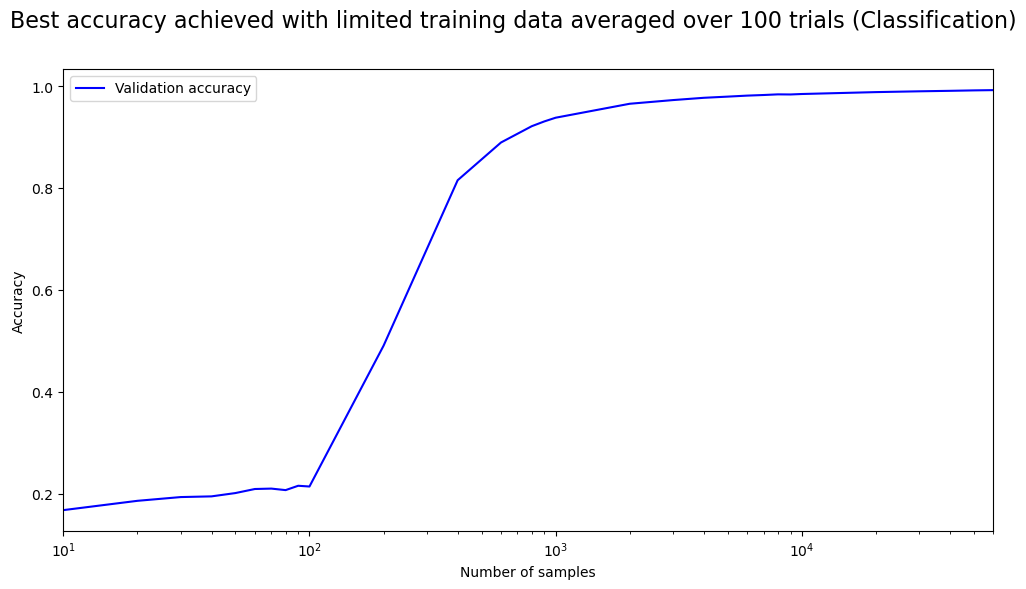

'<table>\n<tbody>\n<tr><td style="text-align: right;">10        </td><td style="text-align: right;">20        </td><td style="text-align: right;">30        </td><td style="text-align: right;">40        </td><td style="text-align: right;">50        </td><td style="text-align: right;">60        </td><td style="text-align: right;">70        </td><td style="text-align: right;">80        </td><td style="text-align: right;">90        </td><td style="text-align: right;">100        </td><td style="text-align: right;">200       </td><td style="text-align: right;">400        </td><td style="text-align: right;">600        </td><td style="text-align: right;">800         </td><td style="text-align: right;">900         </td><td style="text-align: right;">1000         </td><td style="text-align: right;">2000         </td><td style="text-align: right;">3000         </td><td style="text-align: right;">4000         </td><td style="text-align: right;">5000         </td><td style="text-align: right;">6000         </td><td style="text-align: right;">7000         </td><td style="text-align: right;">8000          </td><td style="text-align: right;">9000         </td><td style="text-align: right;">10000         </td><td style="text-align: right;">20000          </td><td style="text-align: right;">30000          </td><td style="text-align: right;">40000          </td><td style="text-align: right;">50000          </td><td style="text-align: right;">60000          </td></tr>\n<tr><td style="text-align: right;"> 0.1675   </td><td style="text-align: right;"> 0.18576  </td><td style="text-align: right;"> 0.193135 </td><td style="text-align: right;"> 0.194499 </td><td style="text-align: right;"> 0.200984 </td><td style="text-align: right;"> 0.20896  </td><td style="text-align: right;"> 0.209764 </td><td style="text-align: right;"> 0.206793 </td><td style="text-align: right;"> 0.215322 </td><td style="text-align: right;">  0.213869 </td><td style="text-align: right;">  0.490324</td><td style="text-align: right;">  0.815243 </td><td style="text-align: right;">  0.889344 </td><td style="text-align: right;">  0.921311  </td><td style="text-align: right;">  0.930722  </td><td style="text-align: right;">   0.937969  </td><td style="text-align: right;">   0.965379  </td><td style="text-align: right;">   0.972615  </td><td style="text-align: right;">   0.977081  </td><td style="text-align: right;">   0.979392  </td><td style="text-align: right;">   0.981368  </td><td style="text-align: right;">   0.982566  </td><td style="text-align: right;">   0.98383    </td><td style="text-align: right;">   0.983616  </td><td style="text-align: right;">    0.984528  </td><td style="text-align: right;">    0.988249   </td><td style="text-align: right;">    0.989827   </td><td style="text-align: right;">    0.990772   </td><td style="text-align: right;">    0.991638   </td><td style="text-align: right;">    0.992155   </td></tr>\n<tr><td style="text-align: right;"> 0.0487894</td><td style="text-align: right;"> 0.0447398</td><td style="text-align: right;"> 0.0565546</td><td style="text-align: right;"> 0.0469004</td><td style="text-align: right;"> 0.0511896</td><td style="text-align: right;"> 0.0656598</td><td style="text-align: right;"> 0.0650223</td><td style="text-align: right;"> 0.0636022</td><td style="text-align: right;"> 0.0716624</td><td style="text-align: right;">  0.0727674</td><td style="text-align: right;">  0.104669</td><td style="text-align: right;">  0.0367257</td><td style="text-align: right;">  0.0188779</td><td style="text-align: right;">  0.00944259</td><td style="text-align: right;">  0.00800898</td><td style="text-align: right;">   0.00637517</td><td style="text-align: right;">   0.00218322</td><td style="text-align: right;">   0.00175513</td><td style="text-align: right;">   0.00157548</td><td style="text-align: right;">   0.00134526</td><td style="text-align: right;">   0.00121284</td><td style="text-align: right;">   0.00116329</td><td style="text-align: righ

In [14]:
data_point_x = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 400, 600, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000]
data_point_values = []
for i in tqdm_notebook(range(100)):
    data_points = []
    for c in data_point_x:
        model = MnistCnn(10).to(device)
        best_acc = classification(model, epochs=10, training_sample_count=c)
        data_points.append(best_acc)
    data_point_values.append(data_points)
aggregated_values = [sum(values) / len(values) for values in zip(*data_point_values)]
plot_progress = Plots(charts={"Validation accuracy": "b"}, title="Best accuracy achieved with limited training data averaged over 100 trials (Classification)", log_x=True, x_axis_title="Number of samples", y_axis_title="Accuracy")
for c, best_acc in zip(data_point_x, aggregated_values):
    plot_progress.add_point("Validation accuracy", c, best_acc)
    plot_progress.plot()
plot_progress.close()

aggregated_values_sq = [sum([v*v for v in values])/len(values) for values in zip(*data_point_values)]
aggregated_values_stdev = [math.sqrt(sq - avg*avg) for sq, avg in zip(aggregated_values_sq, aggregated_values)]
tabulate.tabulate([data_point_x, aggregated_values, aggregated_values_stdev], tablefmt='html')

# Supervised Siamese model

## Dataloaders

In [15]:
def samples_to_generators(inputs, targets):
    ds = torch.utils.data.TensorDataset(inputs, targets)
    ds_loader = torch.utils.data.DataLoader(
        ds,
        shuffle=False,
        batch_size=1,
        num_workers=16,
        prefetch_factor=2,
    )
    samples = [[] for i in range(10)]
    for X, y in ds_loader:
        samples[y].append(X)

    if min(len(samples[i]) for i in range(class_count)) == 0:
        return []
    
    # Test dataloader
    return [
        torch.utils.data.TensorDataset(torch.cat(samples[i]))
        for i in range(class_count)
    ]

test_data = SiameseDataset(samples_to_generators(mnist_test_data, mnist_test_targets))
test_loader_sl = SiameseDataLoader(test_data, batch_size=batch_size_sl)

## Training and testing function

In [16]:
def accuracy(v1, v2):
    scores = torch.matmul(v1, v2.permute(*range(v2.dim() - 2), -1, -2))
    # scores = torch.mm(v1, v2.t())
    m = torch.argmax(scores, dim=-1).to(v1.device)
    i = torch.arange(scores.shape[-1]).to(v1.device)

    if scores.dim() - i.dim() > 1:
        i = i.expand([*scores.shape[:-2], -1])

    marks = torch.where(i == m, torch.tensor(1).to(v1.device), torch.tensor(0).to(v1.device))
    return torch.sum(marks)

def train_sl(dataloader, model, loss_fn, regularization, optimizer, device):
    model.train()
    total_loss = 0
    total_acc = 0
    num_samples = 0
    model = SiameseModel(model).to(device)
    for batch, (s1, s2) in enumerate(dataloader):
        s1, s2 = s1.to(device), s2.to(device)

        batch_size = s1.shape[0]
        class_size = s1.shape[1]
        
        s1 = s1.view(-1, s1.shape[-3], s1.shape[-2], s1.shape[-1])
        s2 = s2.view(-1, s1.shape[-3], s2.shape[-2], s2.shape[-1])
        
        o1, o2 = model((s1, s2))

        o1 = o1.view(batch_size, class_size, -1)
        o2 = o2.view(batch_size, class_size, -1)

        v1 = nn.functional.normalize(o1, dim=-1)
        v2 = nn.functional.normalize(o2, dim=-1)
        
        outputs = torch.stack([o1, o2], dim=0)
        loss = loss_fn(v1, v2) + regularization(outputs)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item() * batch_size * class_size
        total_acc += accuracy(v1, v2).item()
        num_samples += batch_size * class_size

    total_loss /= num_samples
    total_acc /= num_samples

    return total_loss, total_acc


def test_sl(dataloader, model, loss_fn, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    num_samples = 0
    model = SiameseModel(model).to(device)
    with torch.no_grad():
        for s1, s2 in dataloader:
            s1, s2 = s1.to(device), s2.to(device)
            
            batch_size = s1.shape[0]
            class_size = s1.shape[1]
            
            s1 = s1.view(-1, s1.shape[-3], s1.shape[-2], s1.shape[-1])
            s2 = s2.view(-1, s1.shape[-3], s2.shape[-2], s2.shape[-1])
            
            o1, o2 = model((s1, s2))
            
            o1 = o1.view(batch_size, class_size, -1)
            o2 = o2.view(batch_size, class_size, -1)

            v1 = torch.nn.functional.normalize(o1, dim=-1)
            v2 = torch.nn.functional.normalize(o2, dim=-1)

            test_loss += loss_fn(v1, v2).item() * batch_size * class_size
            test_acc += accuracy(v1, v2).item()
            num_samples += batch_size * class_size
    test_loss /= num_samples
    test_acc /= num_samples

    return test_loss, test_acc

In [17]:
def jem_sl(model, loss_fn, regularization, plot_title="Training a classification model",
           epochs=20, silent=True, training_sample_count=60000, lr_multiplier=1.0):
    generator = samples_to_generators(mnist_data[:training_sample_count],
                                      mnist_targets[:training_sample_count])
    if len(generator) == 0:
        if silent:
            return None, 0
        else:
            return None, 0, None
    training_data = SiameseDataset(generator)
    train_loader_sl = SiameseDataLoader(training_data, batch_size=batch_size_sl)

    points_sl = [
        {
            "x": "0",
            "y": 0.001 * lr_multiplier
        },
        {
            "control1": {
                "x": 9 / 20 * epochs,
                "y": 0.001 * lr_multiplier
            },
            "control2": {
                "x": 15 / 20 * epochs,
                "y": 0.00001 * lr_multiplier
            }
        },
        {
            "x": epochs,
            "y": 0.00001 * lr_multiplier
        },
        {
            "x": epochs,
            "y": "0"
        }
    ]

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = TheOneLRScheduler(optimizer, points_sl) 

    if silent:
        best_tower = MnistCnn(latent_size)
        best_acc = 0
    
        for t in range(epochs):
            train_loss, train_acc = train_sl(train_loader_sl, model, loss_fn, regularization, optimizer, device)
            test_loss, test_acc = test_sl(test_loader_sl, model, loss_fn, device)
            scheduler.step()

            if test_acc > best_acc:
                best_acc = test_acc
                best_tower.load_state_dict(model.state_dict())

            train_loader_sl.dataset.shuffle()
            test_loader_sl.dataset.shuffle()

        return best_tower, best_acc
    else:
        best_tower = MnistCnn(latent_size)
        best_acc = 0
        plot_data = []
    
        plot_loss = Plots(charts={"Training loss": "g", "Validation loss": "b"}, title=plot_title, log_y=True, y_axis_title="Loss")
        plot_acc = Plots(charts={"Training accuracy": "g", "Validation accuracy": "b"}, y_axis_title="Accuracy")
        for t in tqdm_notebook(range(epochs)):
            train_loss, train_acc = train_sl(train_loader_sl, model, loss_fn, regularization, optimizer, device)
            test_loss, test_acc = test_sl(test_loader_sl, model, loss_fn, device)
            scheduler.step()

            if test_acc > best_acc:
                best_acc = test_acc
                best_tower.load_state_dict(model.state_dict())
            
            plot_loss.add_point("Training loss", t, train_loss)
            plot_loss.add_point("Validation loss", t, test_loss)
            plot_loss.plot()
            
            plot_acc.add_point("Training accuracy", t, train_acc)
            plot_acc.add_point("Validation accuracy", t, test_acc)
            plot_acc.plot()
            
            if t % 5 == 0:
                embeddings, labels = embed_test_data(model)
                plot_data.append({
                    "epoch": t,
                    "validation_accuracy": test_acc,
                    "embeddings": embeddings,
                    "labels": labels,
                })

            train_loader_sl.dataset.shuffle()
            test_loader_sl.dataset.shuffle()
    
        # making sure the final model is evaluated
        if (epochs-1) % 5 != 0:
            embeddings, labels = embed_test_data(model)
            plot_data.append({
                "epoch": t,
                "validation_accuracy": test_acc,
                "embeddings": embeddings,
                "labels": labels,
            })
            
        plot_loss.close()
        plot_acc.close()
    
        return best_tower, best_acc, plot_data

## Training with limited samples

  0%|          | 0/10 [00:00<?, ?it/s]

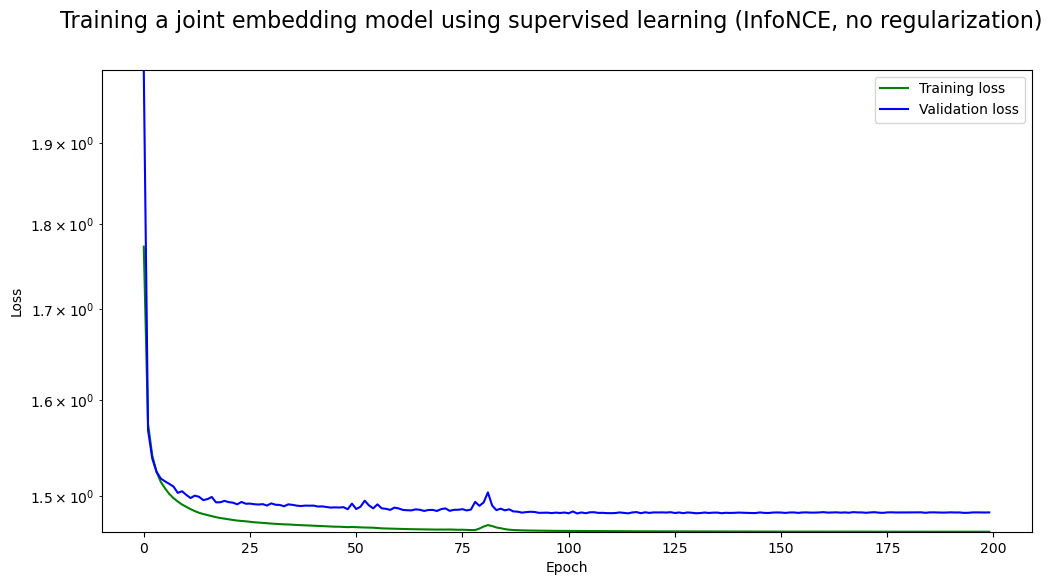

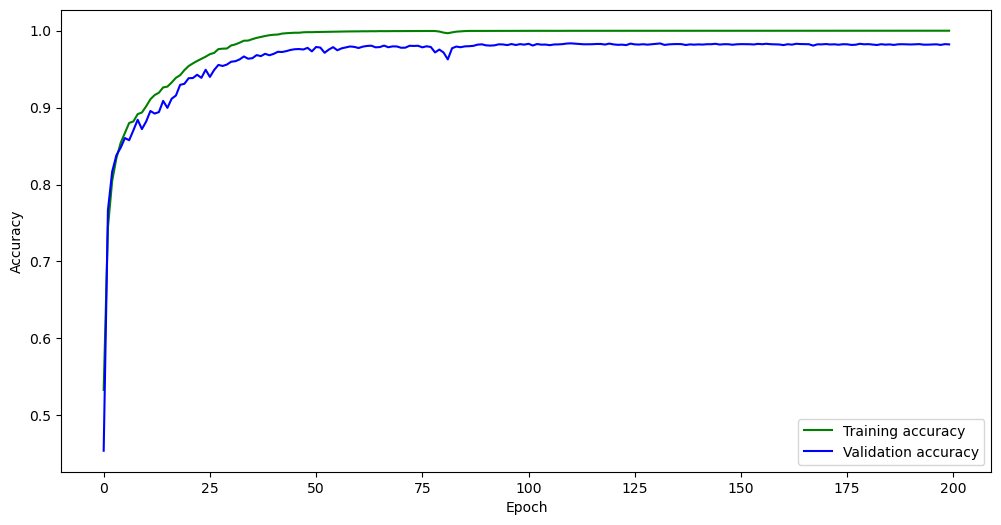

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.983520


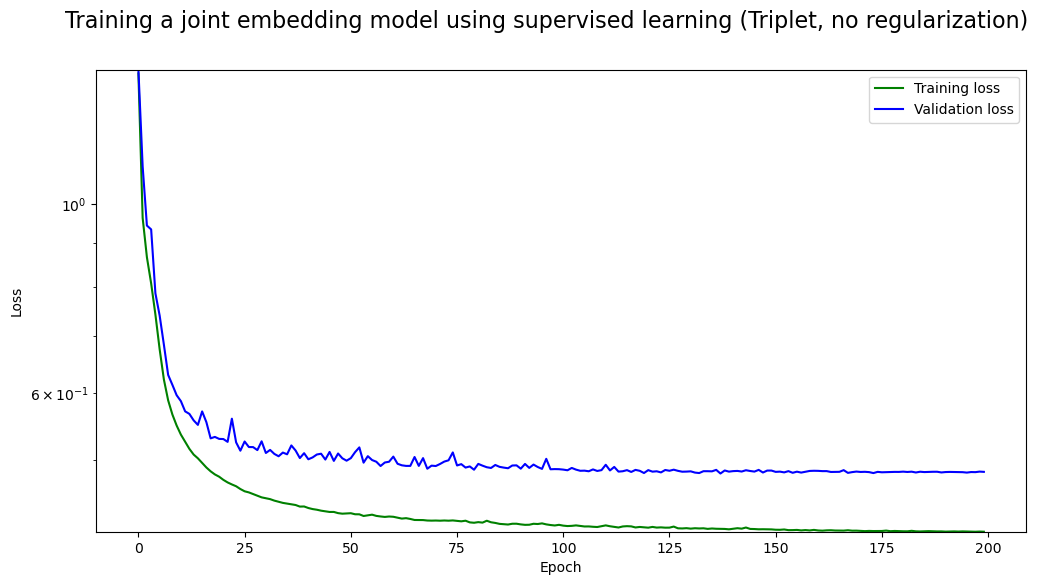

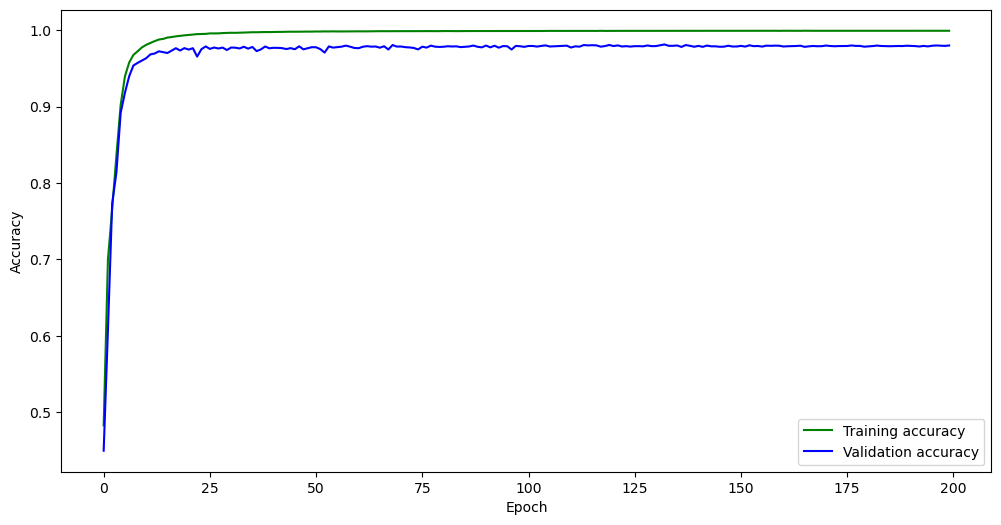

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.981502


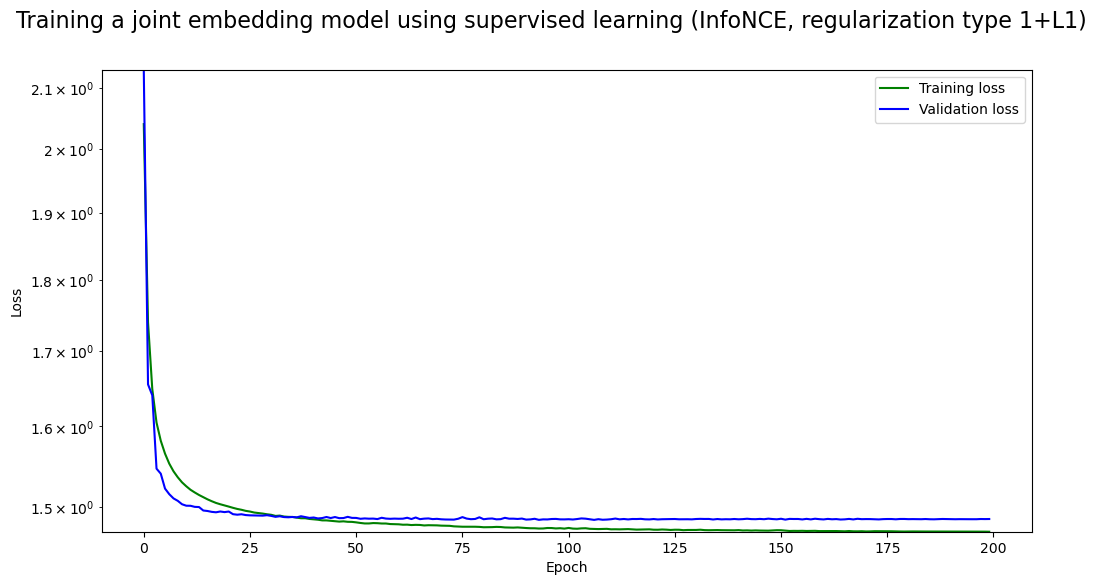

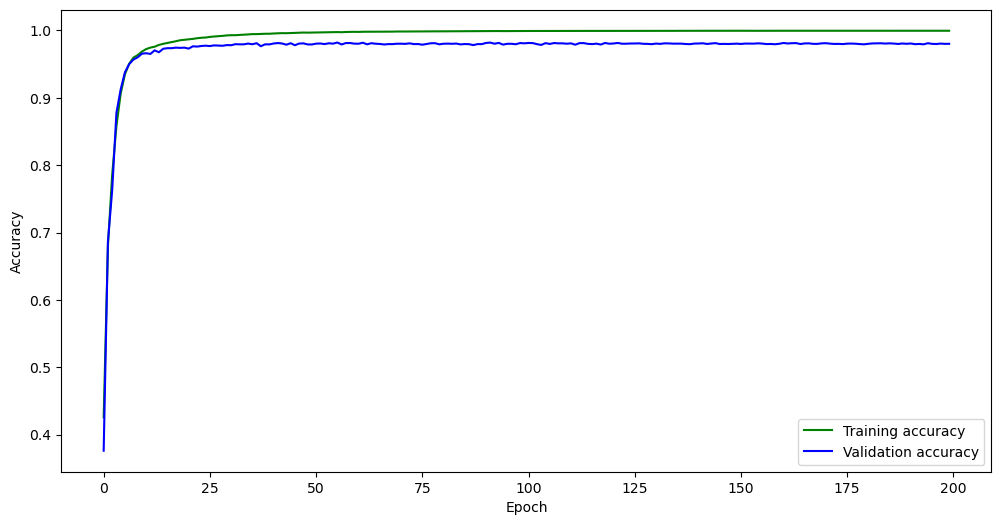

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.981951


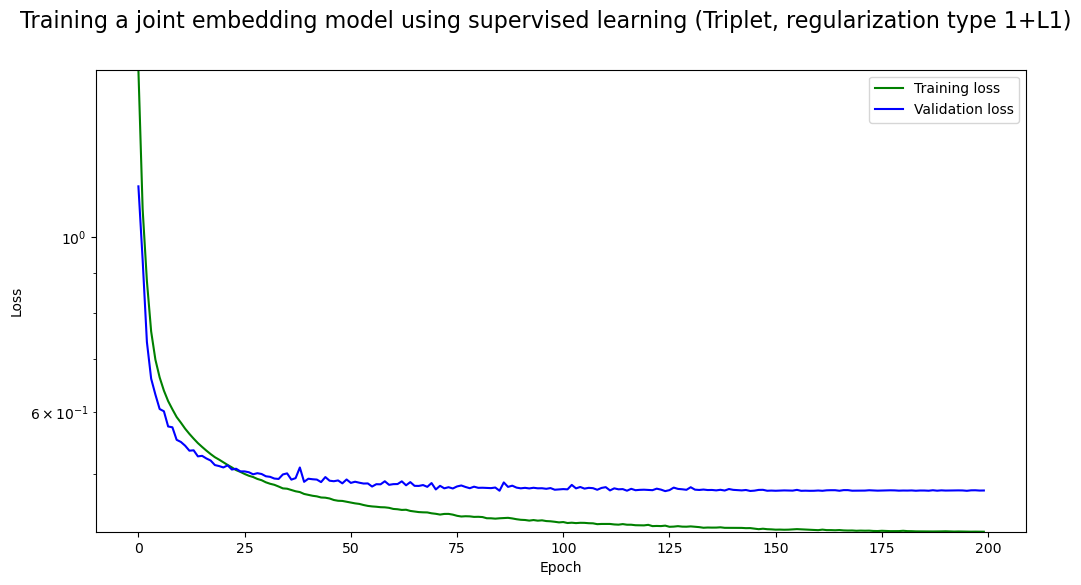

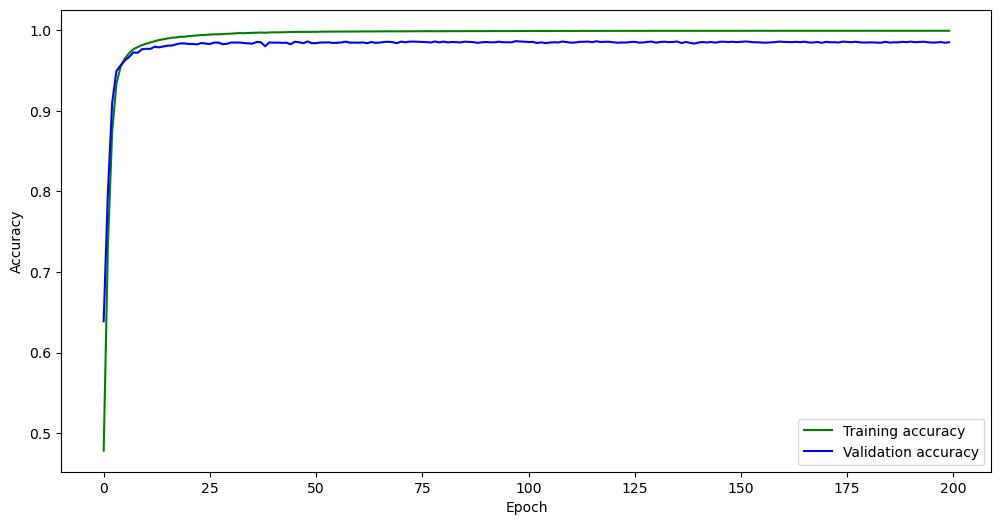

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.986547


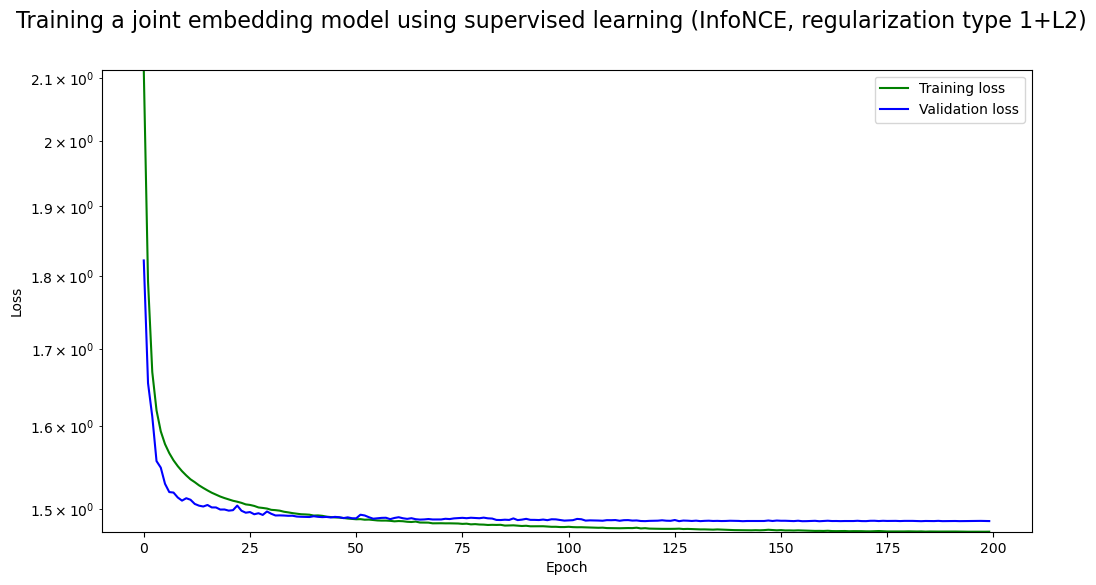

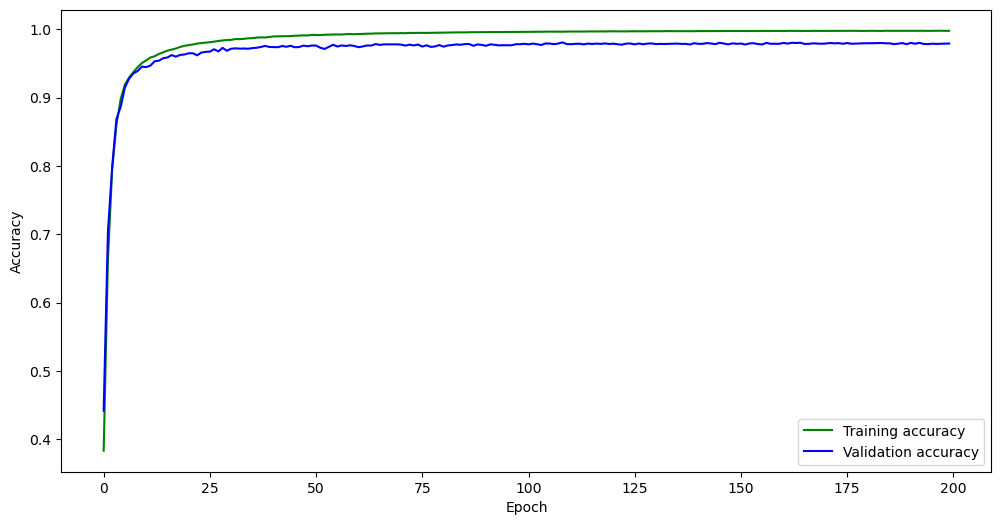

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.980942


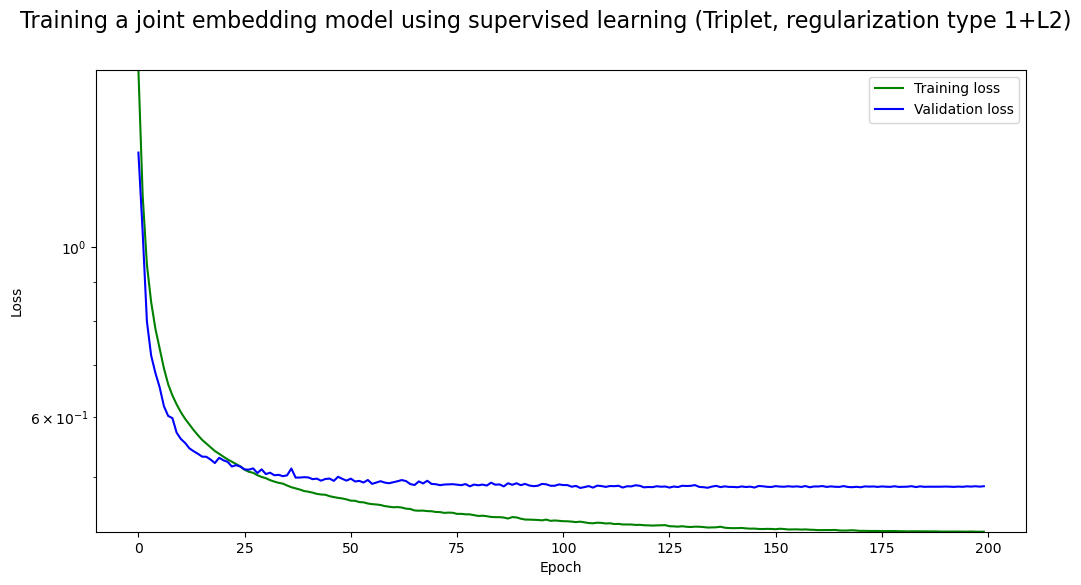

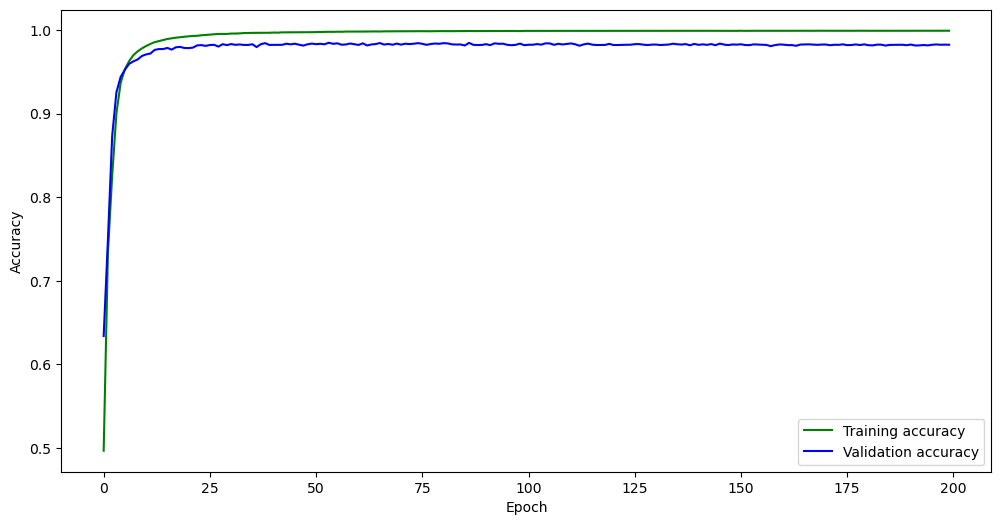

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.984753


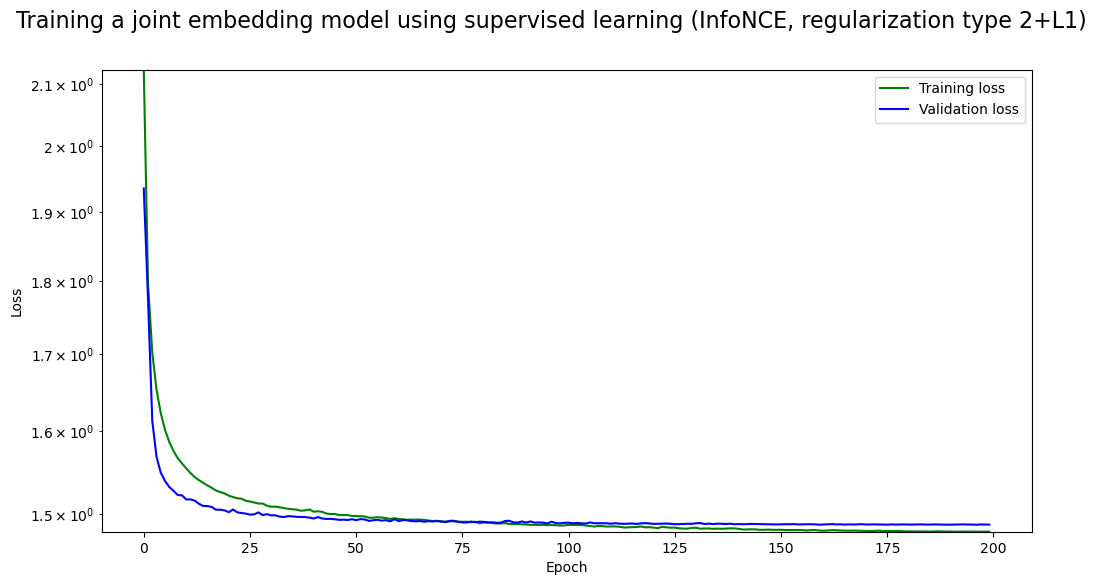

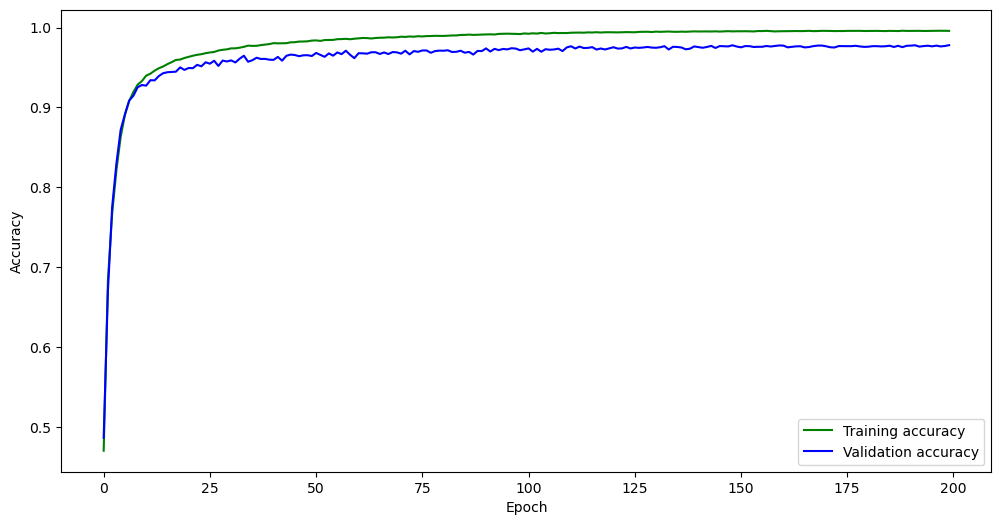

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.978027


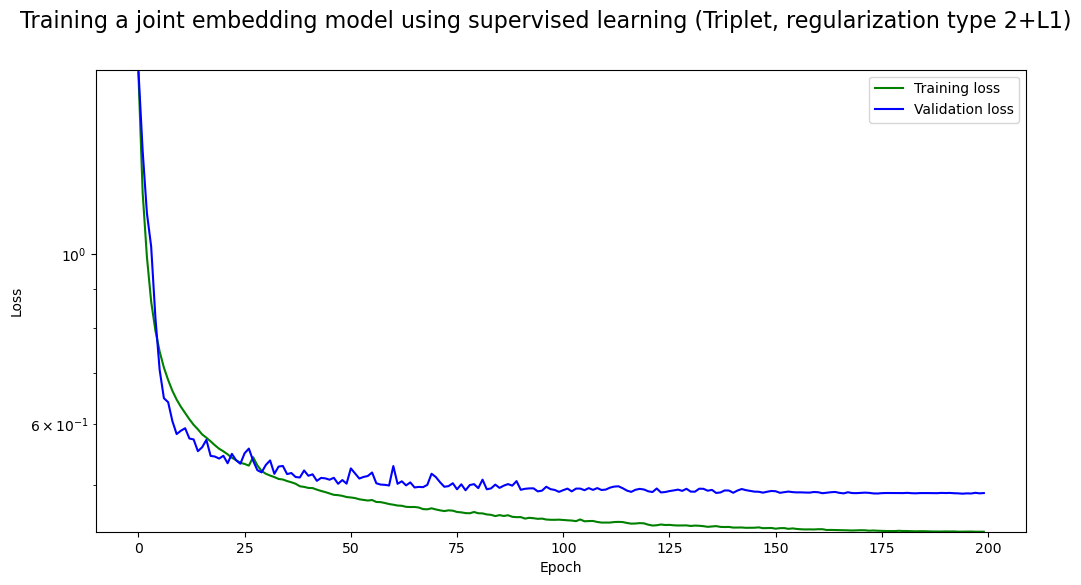

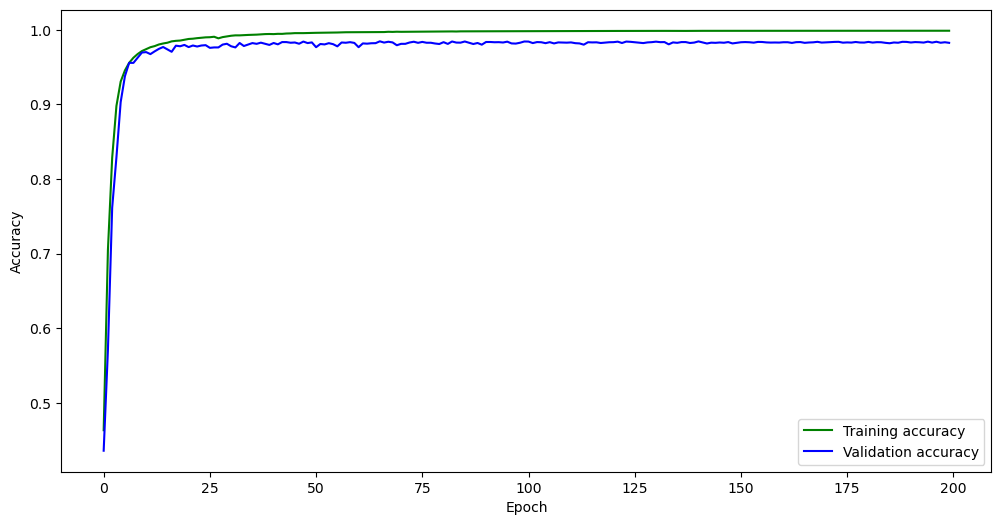

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.984529


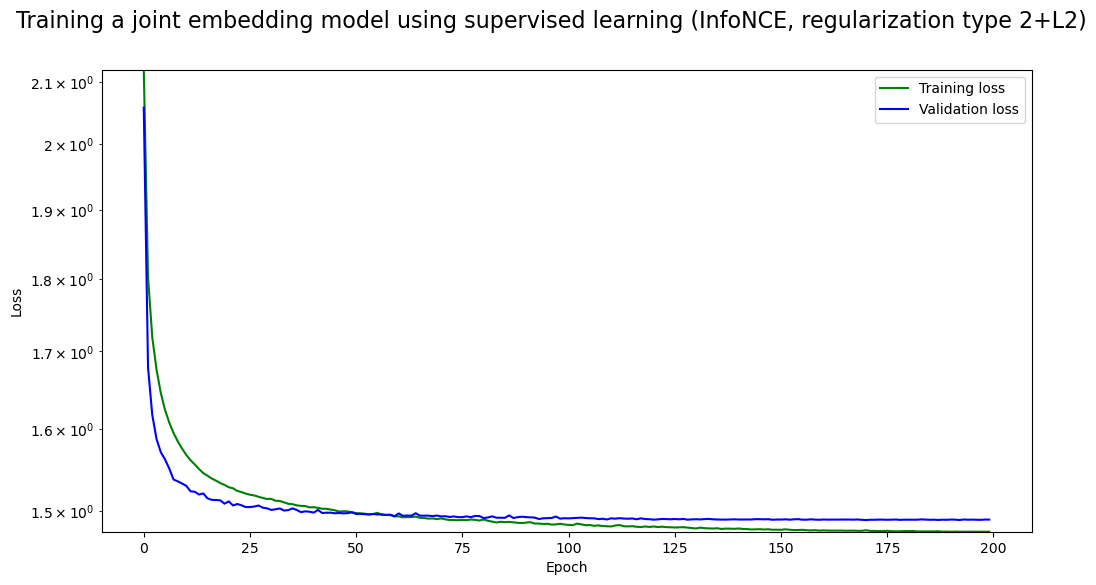

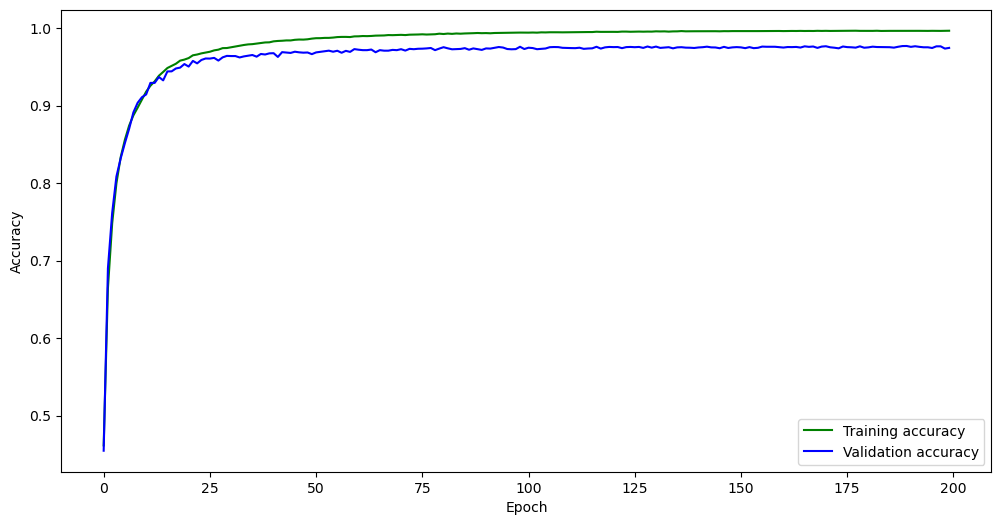

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.977018


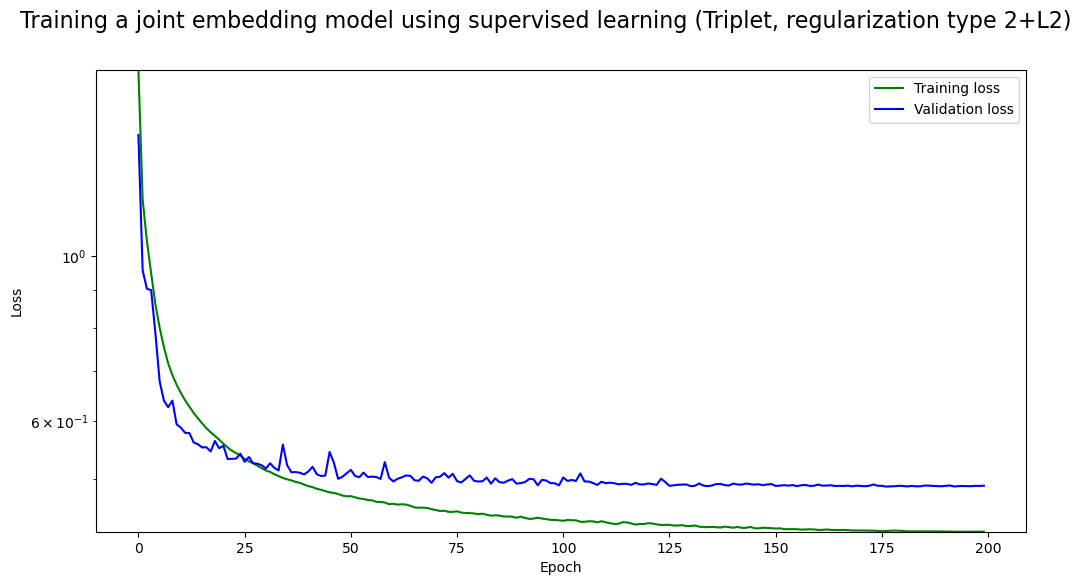

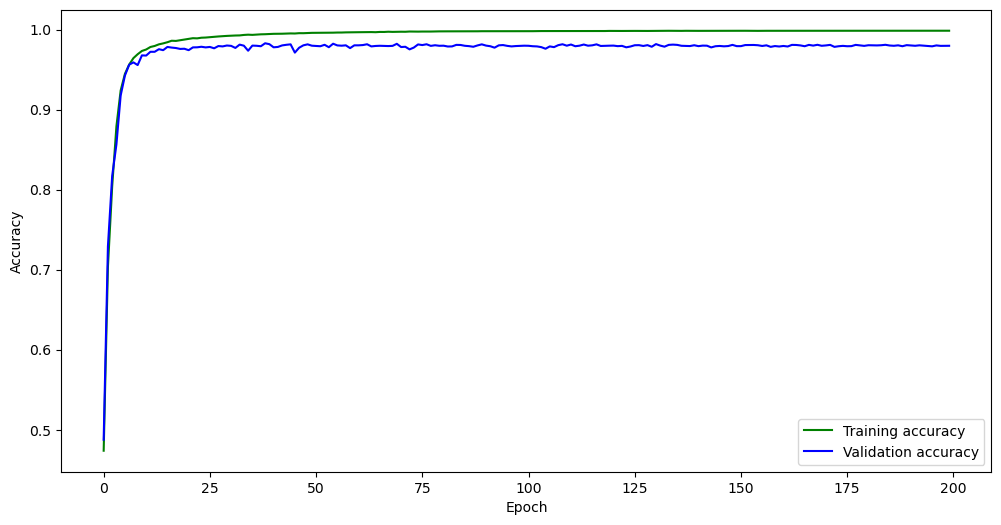

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.982848
{'acc': 0.9865470852017937, 'tower': MnistCnn(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (projector): Sequential(
    (0): Linear(in_features=2048, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
), 'config': {'regularization': <function norm_regularization_1_l1 at 0x7f39bfd4b400>, 'loss_function': <function tri

In [18]:
filename_loss = {
    info_nce_loss: "infonce",
    triplet_loss: "triplet",
}
filename_reg = {
    no_regularization: "noreg",
    norm_regularization_1_l1: "reg1l1",
    norm_regularization_1_l2: "reg1l2",
    norm_regularization_2_l1: "reg2l1",
    norm_regularization_2_l2: "reg2l2",
}

plottitle_loss = {
    info_nce_loss: "InfoNCE",
    triplet_loss: "Triplet",
}

plottitle_reg = {
    no_regularization: "no regularization",
    norm_regularization_1_l1: "regularization type 1+L1",
    norm_regularization_1_l2: "regularization type 1+L2",
    norm_regularization_2_l1: "regularization type 2+L1",
    norm_regularization_2_l2: "regularization type 2+L2",
}

champion_sl = {
    "acc": 0,
    "tower": None,
    "config": None,
}

regularizations = (no_regularization, norm_regularization_1_l1, norm_regularization_1_l2, norm_regularization_2_l1, norm_regularization_2_l2)
loss_functions = (info_nce_loss, triplet_loss)

configs = list(itertools.product(regularizations, loss_functions))

for (reg, loss_fn) in tqdm_notebook(configs):
    plot_title = f"Training a joint embedding model using supervised learning ({plottitle_loss[loss_fn]}, {plottitle_reg[reg]})"
    html_title = f"supervised joint embedding model trained with {plottitle_loss[loss_fn]} loss function and {plottitle_reg[reg]}"
    
    model = MnistCnn(latent_size).to(device)
    best_tower, best_acc, plot_data = jem_sl(model, loss_fn, reg,
                                             plot_title=plot_title,
                                             epochs=200, silent=False)
    export_plotly_html(plot_data, f"sl_charts/{filename_loss[loss_fn]}_{filename_reg[reg]}.html", html_title)
    print(f"Best downstream task accuracy: {best_acc:3f}")
    if champion_sl["acc"] < best_acc:
        champion_sl["acc"] = best_acc
        champion_sl["tower"] = best_tower
        champion_sl["config"] = {
            "regularization": reg,
            "loss_function": loss_fn,
        }

torch.save(champion_sl["tower"], "./champion_tower_sl.pt")
print(champion_sl)

Using the best configuraiton found to test the impact of limited training data

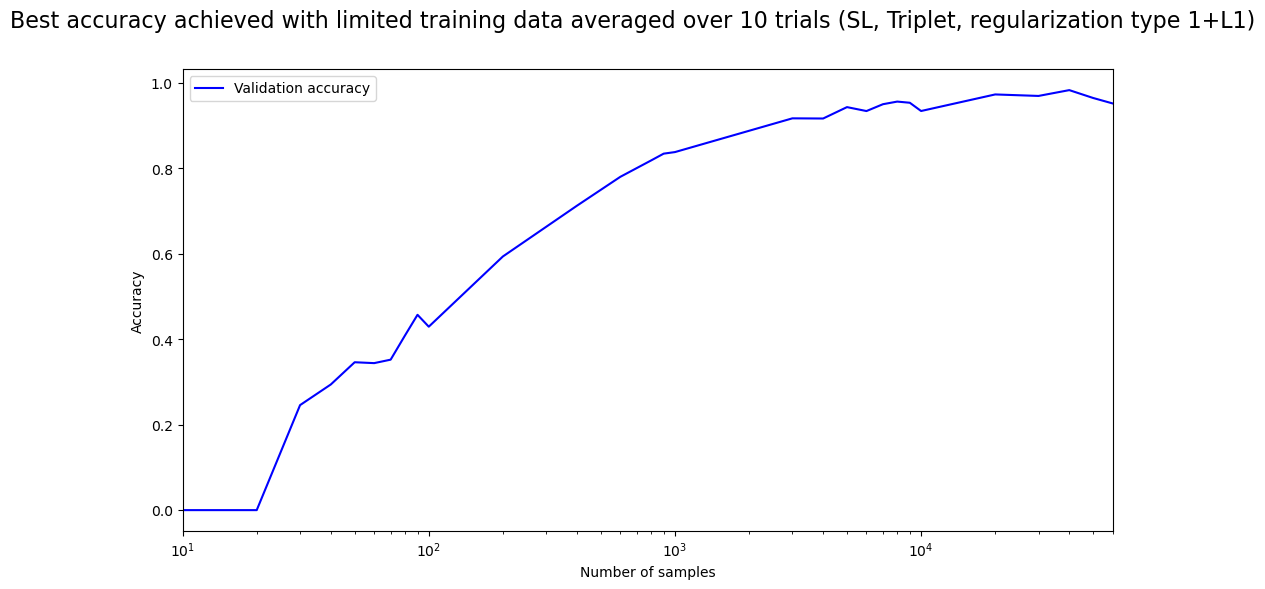

  0%|          | 0/30 [00:00<?, ?it/s]

'<table>\n<tbody>\n<tr><td style="text-align: right;">10</td><td style="text-align: right;">20</td><td style="text-align: right;">30        </td><td style="text-align: right;">40        </td><td style="text-align: right;">50        </td><td style="text-align: right;">60        </td><td style="text-align: right;">70        </td><td style="text-align: right;">80        </td><td style="text-align: right;">90        </td><td style="text-align: right;">100        </td><td style="text-align: right;">200        </td><td style="text-align: right;">400        </td><td style="text-align: right;">600        </td><td style="text-align: right;">800        </td><td style="text-align: right;">900        </td><td style="text-align: right;">1000        </td><td style="text-align: right;">2000        </td><td style="text-align: right;">3000        </td><td style="text-align: right;">4000        </td><td style="text-align: right;">5000        </td><td style="text-align: right;">6000        </td><td style="text-align: right;">7000         </td><td style="text-align: right;">8000         </td><td style="text-align: right;">9000        </td><td style="text-align: right;">10000        </td><td style="text-align: right;">20000         </td><td style="text-align: right;">30000        </td><td style="text-align: right;">40000         </td><td style="text-align: right;">50000        </td><td style="text-align: right;">60000        </td></tr>\n<tr><td style="text-align: right;"> 0</td><td style="text-align: right;"> 0</td><td style="text-align: right;"> 0.245863 </td><td style="text-align: right;"> 0.294238 </td><td style="text-align: right;"> 0.346244 </td><td style="text-align: right;"> 0.344182 </td><td style="text-align: right;"> 0.352309 </td><td style="text-align: right;"> 0.408688 </td><td style="text-align: right;"> 0.457343 </td><td style="text-align: right;">  0.429496 </td><td style="text-align: right;">  0.59389  </td><td style="text-align: right;">  0.712791 </td><td style="text-align: right;">  0.780404 </td><td style="text-align: right;">  0.8187   </td><td style="text-align: right;">  0.834652 </td><td style="text-align: right;">   0.838307 </td><td style="text-align: right;">   0.888161 </td><td style="text-align: right;">   0.917321 </td><td style="text-align: right;">   0.916928 </td><td style="text-align: right;">   0.943599 </td><td style="text-align: right;">   0.934395 </td><td style="text-align: right;">   0.950415  </td><td style="text-align: right;">   0.956547  </td><td style="text-align: right;">   0.953823 </td><td style="text-align: right;">    0.934496 </td><td style="text-align: right;">    0.973285  </td><td style="text-align: right;">    0.969787 </td><td style="text-align: right;">    0.983397  </td><td style="text-align: right;">    0.965    </td><td style="text-align: right;">    0.952231 </td></tr>\n<tr><td style="text-align: right;"> 0</td><td style="text-align: right;"> 0</td><td style="text-align: right;"> 0.0196263</td><td style="text-align: right;"> 0.0236705</td><td style="text-align: right;"> 0.0392843</td><td style="text-align: right;"> 0.0251703</td><td style="text-align: right;"> 0.0426578</td><td style="text-align: right;"> 0.0355906</td><td style="text-align: right;"> 0.0480952</td><td style="text-align: right;">  0.0227631</td><td style="text-align: right;">  0.0218237</td><td style="text-align: right;">  0.0345164</td><td style="text-align: right;">  0.0217081</td><td style="text-align: right;">  0.0192375</td><td style="text-align: right;">  0.0177482</td><td style="text-align: right;">   0.0170746</td><td style="text-align: right;">   0.0269947</td><td style="text-align: right;">   0.0089983</td><td style="text-align: right;">   0.0459299</td><td style="text-align: right;">   0.0045779</td><td style="text-align: right;">   0.0282767</td><td style="text-align: right;">   0.00340484</td><td style="text-align: right;">   0.00469173</td><td style="text-align: right;">   0.0291327</td><td style="text-align

In [19]:
data_point_x = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 400, 600, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000]
data_point_values = []
plot_progress = Plots(charts={"Validation accuracy": "b"},
                      title=f"Best accuracy achieved with limited training data averaged over 10 trials (SL, {plottitle_loss[champion_sl['config']['loss_function']]}, {plottitle_reg[champion_sl['config']['regularization']]})",
                      log_x=True, x_axis_title="Number of samples", y_axis_title="Accuracy")
avg_acc_list = []
stdev_acc_list = []
for training_sample_count in tqdm_notebook(data_point_x):
    sum_acc = 0
    sq_sum_acc = 0
    for i in range(10):
        model = MnistCnn(latent_size).to(device)
        _, best_acc = jem_sl(model, champion_sl["config"]["loss_function"], champion_sl["config"]["regularization"], epochs=200, silent=True, training_sample_count=training_sample_count)
        sum_acc += best_acc
        sq_sum_acc += best_acc * best_acc
    avg_acc = sum_acc / 10
    stdev_acc = math.sqrt(max(0, sq_sum_acc/10 - avg_acc*avg_acc))
    plot_progress.add_point("Validation accuracy", training_sample_count, avg_acc)
    plot_progress.plot()
    avg_acc_list.append(avg_acc)
    stdev_acc_list.append(stdev_acc)
plot_progress.close()
tabulate.tabulate([data_point_x, avg_acc_list, stdev_acc_list], tablefmt='html')

# Self-supervised learning

## Dataloaders

In [20]:
class MnistSslDatasetWithTransform(torch.utils.data.Dataset):
    def __init__(self, data, device, augment=False, augment_both_sides=False):
        super(MnistSslDatasetWithTransform, self).__init__()
        self.device = device
        self.augment_both_sides = augment_both_sides
        self.augment = augment
        images = []
        load_image = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((32, 32), antialias=True),
        ])
        self.dataset = [load_image(img).to(device) for img, _ in data]
        self.target = torch.zeros(1, device='cpu')
        self.transform1 = transforms.Compose([
            transforms.Normalize(mean=[0.912], std=[0.168]),
        ])
        self.transform2 = transforms.Compose([
            transforms.RandomAffine((-10, 10), (0.1, 0.1), (0.8, 1.2), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.Normalize(mean=[0.912], std=[0.168]),
        ])

    def __getitem__(self, index):
        img = self.dataset[index]

        if self.augment:
            if not self.augment_both_sides:
                img1 = self.transform1(img)
            else:
                img1 = self.transform2(img)
            img2 = self.transform2(img)
        else:
            img1 = self.transform1(img)
            img2 = self.transform1(img)
        inputs = torch.stack([img1, img2])

        return inputs, self.target

    def __len__(self):
        return len(self.dataset)


class SimpleCustomBatch:
    def __init__(self, inputs, targets):
        self.inputs, self.targets = inputs, targets # zip(*samples)
        
    # custom memory pinning method on custom type
    def pin_memory(self):
        self.inputs = self.inputs.pin_memory()
        # self.targets = self.targets.pin_memory()
        return self

def collator(samples):
    inputs, targets = zip(*samples)
    inputs = torch.stack(list(inputs))
    return SimpleCustomBatch(inputs.view(-1, inputs.shape[-3], inputs.shape[-2], inputs.shape[-1]), targets)

In [21]:
train_mnist_ssl = datasets.MNIST(
    root="data",
    train=True,
    download=True,
)
train_loader_ssl = torch.utils.data.DataLoader(
    MnistSslDatasetWithTransform(train_mnist_ssl, device='cpu', augment=True, augment_both_sides=False),
    collate_fn=collator,
    shuffle=True,
    batch_size=batch_size_ssl,
    num_workers=16,
    prefetch_factor=2,
    pin_memory=True,
    pin_memory_device=device,
)

test_mnist_ssl = datasets.MNIST(
    root="data",
    train=False,
    download=True,
)
test_loader_ssl = torch.utils.data.DataLoader(
    MnistSslDatasetWithTransform(test_mnist_ssl, device='cpu', augment=True, augment_both_sides=False),
    collate_fn=collator,
    shuffle=False,
    batch_size=batch_size_ssl,
    num_workers=16,
    prefetch_factor=2,
    pin_memory=True,
    pin_memory_device=device,
)

## Training and testing functions

In [22]:
def train_ssl(dataloader, model, loss_fn, regularization, optimizer, device):
    model.train()
    total_loss = 0
    total_acc = 0
    num_samples = 0

    for batch, pinned in enumerate(dataloader):
        if isinstance(pinned, tuple):
            (inputs, targets) = pinned
        else:
            (inputs, targets) = pinned.inputs, pinned.targets
        inputs = inputs.to(device)

        # Compute prediction error
        outputs = model(inputs)

        vectors = nn.functional.normalize(outputs, dim=-1)
        vectors = vectors.view(vectors.shape[0]//2, 2, vectors.shape[-1])
        v1 = vectors[:, 0, :]
        v2 = vectors[:, 1, :]
        loss = loss_fn(v1, v2) + regularization(outputs)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item() * v1.shape[0]
        total_acc += accuracy(v1, v2).item()
        num_samples += v1.shape[0]

    total_loss /= num_samples
    total_acc /= num_samples

    return total_loss, total_acc


def test_ssl(dataloader, model, loss_fn, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    num_samples = 0
    with torch.no_grad():
        for pinned in dataloader:
            if isinstance(pinned, tuple):
                (inputs, targets) = pinned
            else:
                (inputs, targets) = pinned.inputs, pinned.targets
            inputs = inputs.to(device)
            outputs = model(inputs)

            vectors = nn.functional.normalize(outputs, dim=-1)
            vectors = vectors.view(vectors.shape[0]//2, 2, vectors.shape[-1])
            v1 = vectors[:, 0, :]
            v2 = vectors[:, 1, :]
            test_loss += loss_fn(v1, v2).item() * v1.shape[0]
            test_acc += accuracy(v1, v2).item()
            num_samples += v1.shape[0]
        test_loss /= num_samples
        test_acc /= num_samples

    return test_loss, test_acc

def fine_tune_downstream_task(model, epochs=10, training_sample_count=60000):
    labeled_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(mnist_data[:training_sample_count], mnist_targets[:training_sample_count]),
        shuffle=True,
        batch_size=training_sample_count,
        num_workers=16,
        prefetch_factor=2,
    )
    downstream_model = MnistCnnkNN(model, labeled_loader, 10, device)
    return classification(downstream_model, epochs=epochs, training_sample_count=training_sample_count, lr_multiplier=1)

In [23]:
def jem_ssl(model, loss_fn, regularization, plot_title="Training a self-supervised model", finetune_with_sl=True,
            epochs=20, downstream_epochs=20, downstream_sample_count=40, silent=True, lr_multiplier=1):
    generator = samples_to_generators(mnist_data[:downstream_sample_count],
                                      mnist_targets[:downstream_sample_count])
    if len(generator) == 0:
        if silent:
            return None, 0
        else:
            return None, 0, None
    training_data = SiameseDataset(generator)
    train_loader_sl = SiameseDataLoader(training_data, batch_size=batch_size_sl)

    points_ssl = [
        {
            "x": "0",
            "y": 0.001 * lr_multiplier
        },
        {
            "control1": {
                "x": 9 / 20 * epochs,
                "y": 0.001 * lr_multiplier
            },
            "control2": {
                "x": 15 / 20 * epochs,
                "y": 0.00001 * lr_multiplier
            }
        },
        {
            "x": epochs,
            "y": 0.00001 * lr_multiplier
        },
        {
            "x": epochs,
            "y": "0"
        }
    ]

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = TheOneLRScheduler(optimizer, points_ssl) 

    if silent:
        best_tower = MnistCnn(latent_size)
        best_acc = 0
    
        for t in range(epochs):
            train_loss_ssl, train_acc_ssl = train_ssl(train_loader_ssl, model, loss_fn, regularization, optimizer, device)
            if finetune_with_sl:
                train_loss_sl, train_acc_sl = train_sl(train_loader_sl, model, loss_fn, regularization, optimizer, device)
            down_stream_acc = fine_tune_downstream_task(model, epochs=downstream_epochs, training_sample_count=downstream_sample_count)
            scheduler.step()

            if down_stream_acc > best_acc:
                best_acc = down_stream_acc
                best_tower.load_state_dict(model.state_dict())

        return best_tower, best_acc
    else:
        best_tower = MnistCnn(latent_size)
        best_acc = 0
        plot_data = []

        if finetune_with_sl:
            plot_loss = Plots(charts={"SSL Training loss": "#17becf", "SSL Validation loss": "#1f77b4",
                                      "SL Training loss": "#ff7f0e", "SL Validation loss": "#d62728"},
                              title=plot_title, log_y=True, y_axis_title="Loss")
            plot_acc = Plots(charts={"SSL Training accuracy": "#17becf", "SSL Validation accuracy": "#1f77b4",
                                     f"SL Training accuracy with {downstream_sample_count} training samples": "#ff7f0e",
                                     f"SL Validation accuracy with {downstream_sample_count} training samples": "#d62728",
                                     f"Downstream accuracy with {downstream_sample_count} training samples": "black"},
                             y_axis_title="Accuracy")
        else:
            plot_loss = Plots(charts={"SSL Training loss": "#17becf",
                                      "SSL Validation loss": "#1f77b4"},
                              title=plot_title, log_y=True, y_axis_title="Loss")
            plot_acc = Plots(charts={"SSL Training accuracy": "#17becf", "SSL Validation accuracy": "#1f77b4",
                                     f"Downstream accuracy with {downstream_sample_count} training samples": "black"},
                             y_axis_title="Accuracy")

        for t in tqdm_notebook(range(epochs)):
            train_loss_ssl, train_acc_ssl = train_ssl(train_loader_ssl, model, loss_fn, regularization, optimizer, device)
            test_loss_ssl, test_acc_ssl = test_ssl(test_loader_ssl, model, loss_fn, device)
            if finetune_with_sl:
                train_loss_sl, train_acc_sl = train_sl(train_loader_sl, model, loss_fn, regularization, optimizer, device)
            test_loss_sl, test_acc_sl = test_sl(test_loader_sl, model, loss_fn, device)
            down_stream_acc = fine_tune_downstream_task(model, epochs=downstream_epochs, training_sample_count=downstream_sample_count)
            scheduler.step()

            if down_stream_acc > best_acc:
                best_acc = down_stream_acc
                best_tower.load_state_dict(model.state_dict())
            
            plot_loss.add_point("SSL Training loss", t, train_loss_ssl)
            plot_loss.add_point("SSL Validation loss", t, test_loss_ssl)
            if finetune_with_sl:
                plot_loss.add_point("SL Training loss", t, train_loss_sl)
                plot_loss.add_point("SL Validation loss", t, test_loss_sl)
            plot_loss.plot()
            
            plot_acc.add_point("SSL Training accuracy", t, train_acc_ssl)
            plot_acc.add_point("SSL Validation accuracy", t, test_acc_ssl)
            if finetune_with_sl:
                plot_acc.add_point(f"SL Training accuracy with {downstream_sample_count} training samples", t, train_acc_sl)
                plot_acc.add_point(f"SL Validation accuracy with {downstream_sample_count} training samples", t, test_acc_sl)
            plot_acc.add_point(f"Downstream accuracy with {downstream_sample_count} training samples", t, down_stream_acc)
            plot_acc.plot()
            
            if t % 5 == 0:
                embeddings, labels = embed_test_data(model)
                plot_data.append({
                    "epoch": t,
                    "validation_accuracy": down_stream_acc,
                    "embeddings": embeddings,
                    "labels": labels,
                })
    
        # making sure the final model is evaluated
        if (epochs-1) % 5 != 0:
            embeddings, labels = embed_test_data(model)
            plot_data.append({
                "epoch": t,
                "validation_accuracy": down_stream_acc,
                "embeddings": embeddings,
                "labels": labels,
            })
            
        plot_loss.close()
        plot_acc.close()
    
        return best_tower, best_acc, plot_data

## Training the model

In [24]:
filename_loss = {
    info_nce_loss: "infonce",
    triplet_loss: "triplet",
}
filename_reg = {
    no_regularization: "noreg",
    norm_regularization_1_l1: "reg1l1",
    norm_regularization_1_l2: "reg1l2",
    norm_regularization_2_l1: "reg2l1",
    norm_regularization_2_l2: "reg2l2",
}

plottitle_loss = {
    info_nce_loss: "InfoNCE",
    triplet_loss: "Triplet",
}

plottitle_reg = {
    no_regularization: "no regularization",
    norm_regularization_1_l1: "regularization type 1+L1",
    norm_regularization_1_l2: "regularization type 1+L2",
    norm_regularization_2_l1: "regularization type 2+L1",
    norm_regularization_2_l2: "regularization type 2+L2",
}

  0%|          | 0/10 [00:00<?, ?it/s]

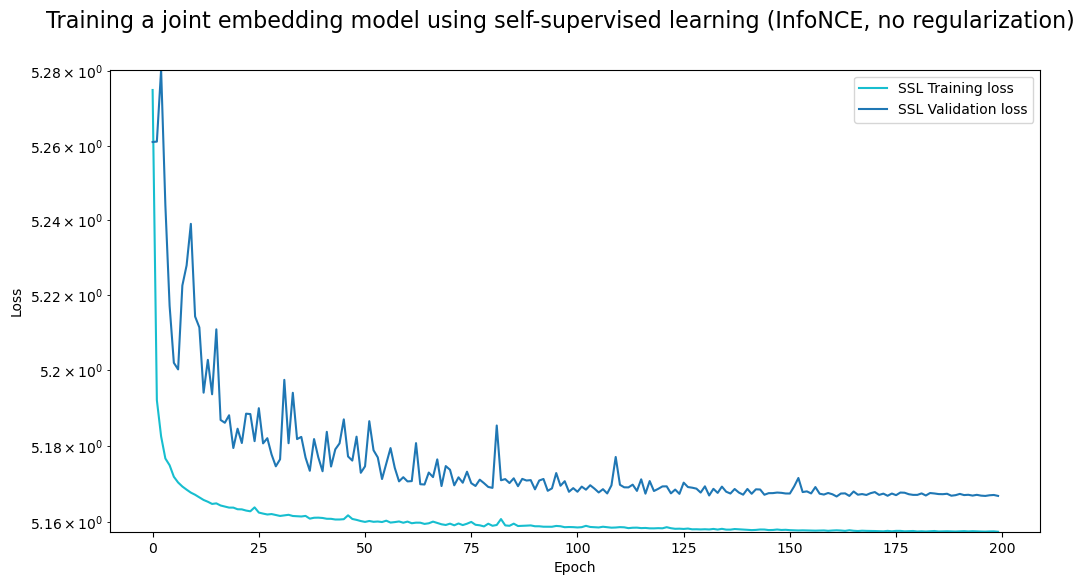

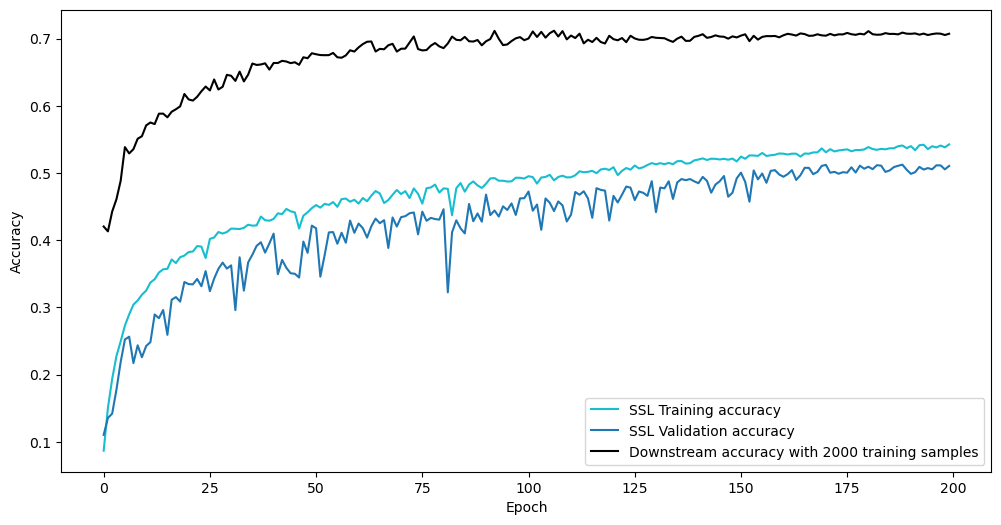

  0%|          | 0/200 [00:00<?, ?it/s]

/home/mehran/.conda/envs/pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


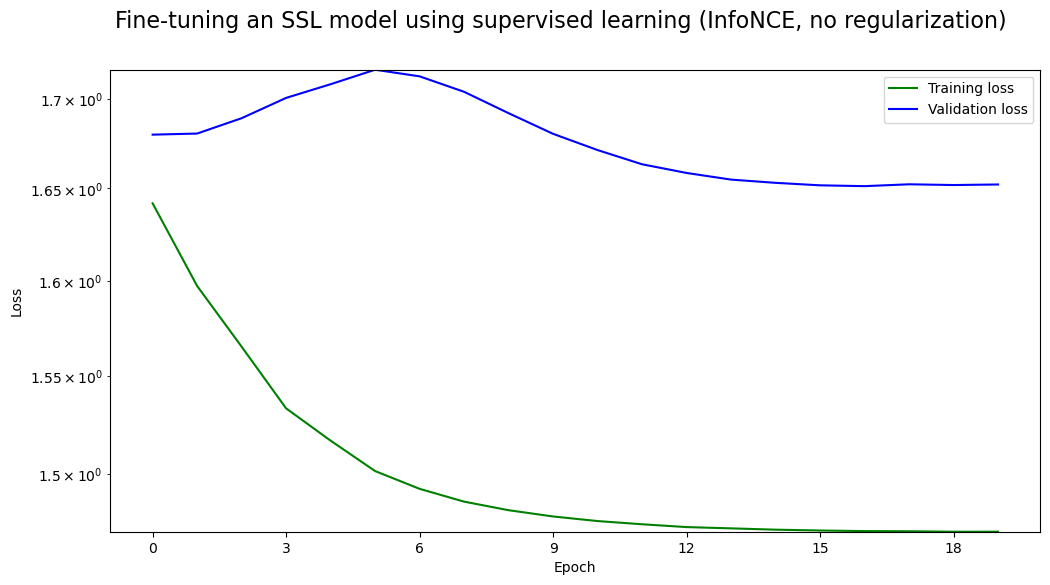

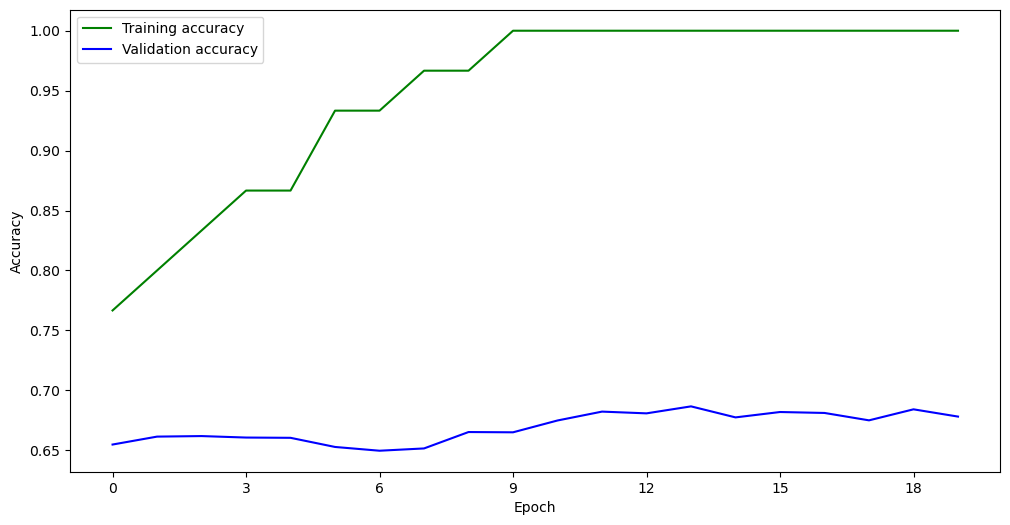

  0%|          | 0/20 [00:00<?, ?it/s]

Best downstream task accuracy: 0.711600


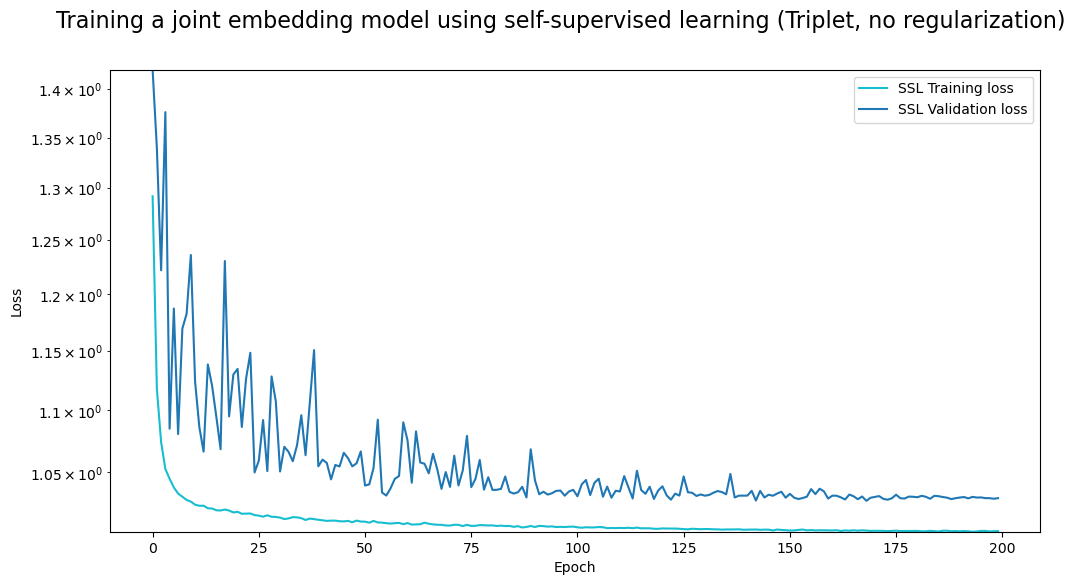

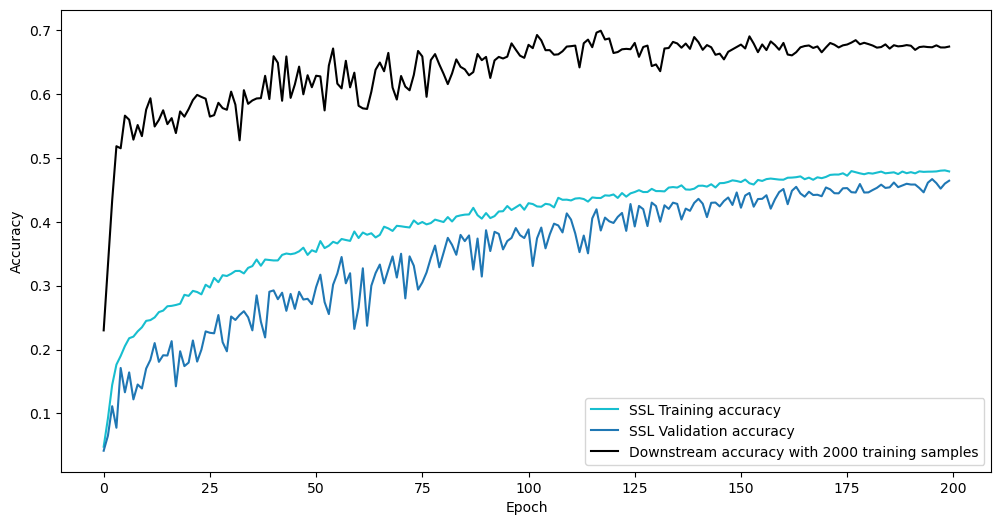

  0%|          | 0/200 [00:00<?, ?it/s]

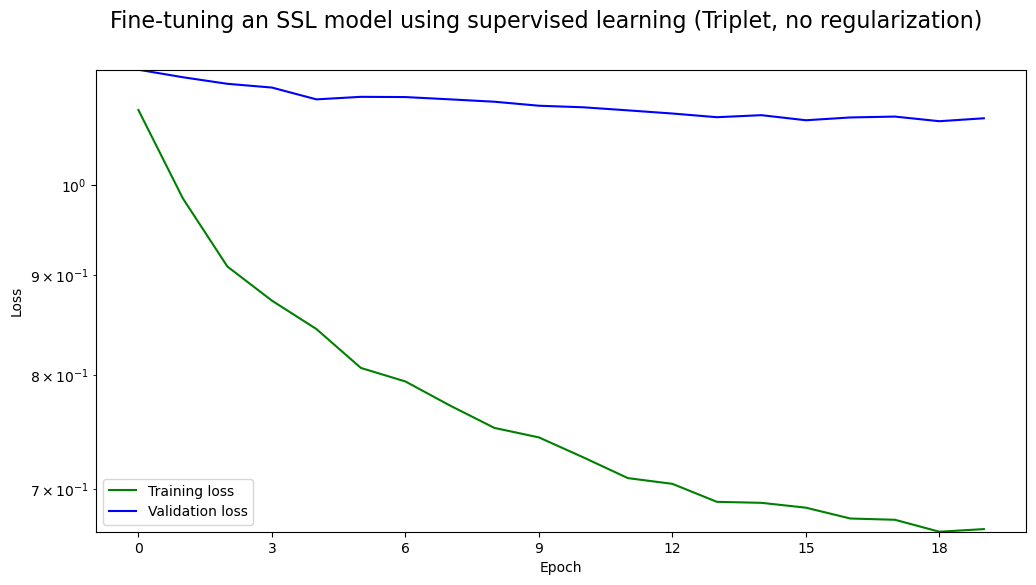

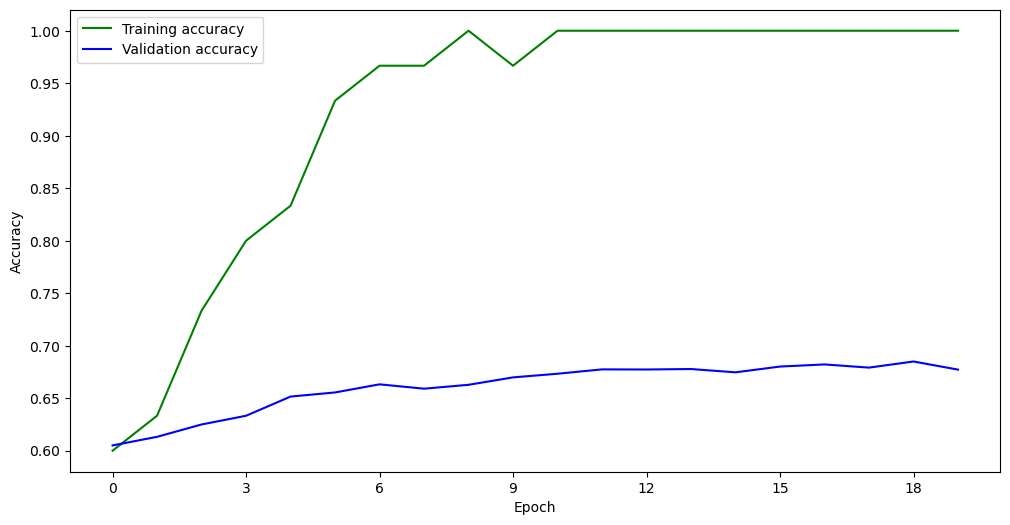

  0%|          | 0/20 [00:00<?, ?it/s]

Best downstream task accuracy: 0.699300


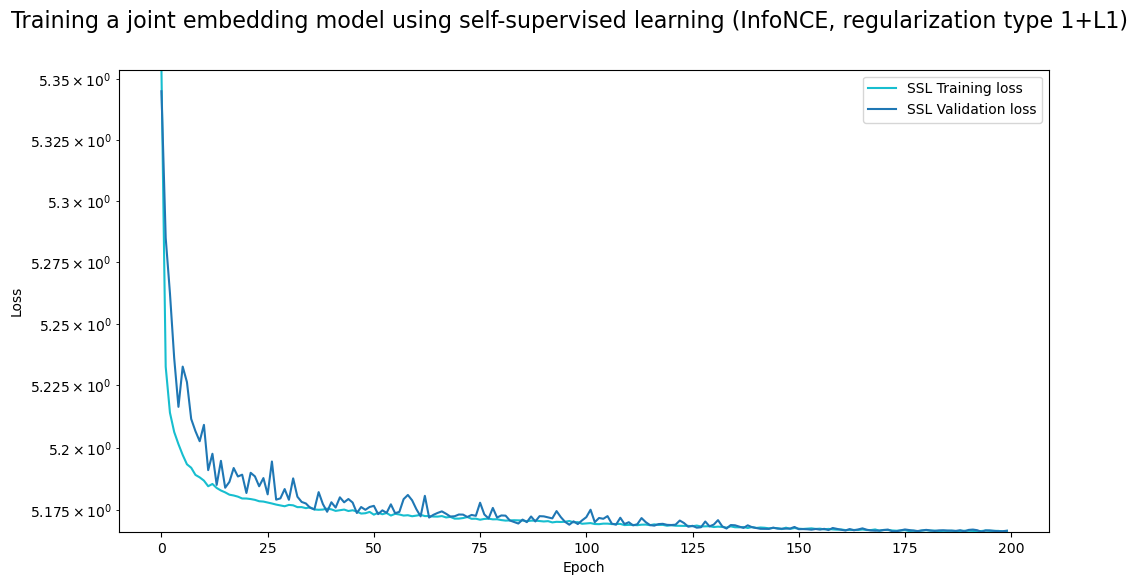

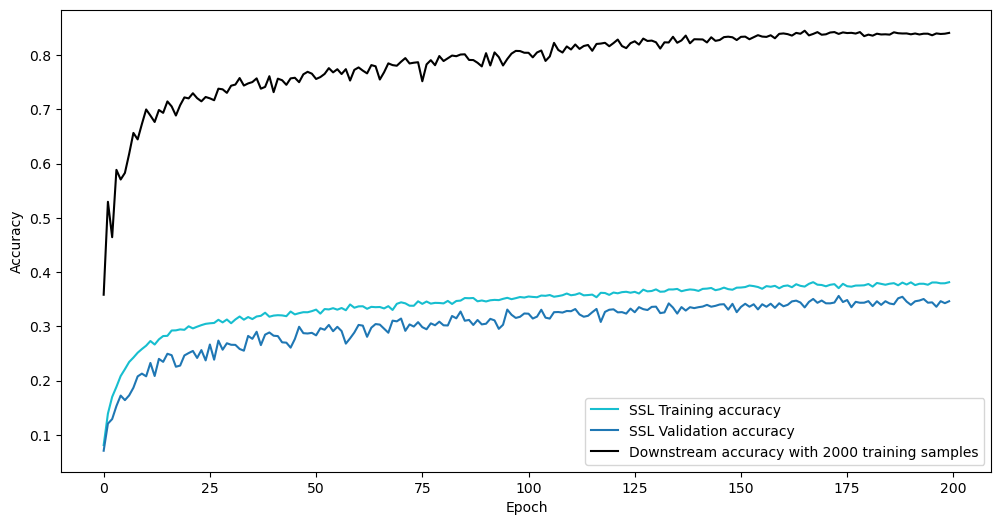

  0%|          | 0/200 [00:00<?, ?it/s]

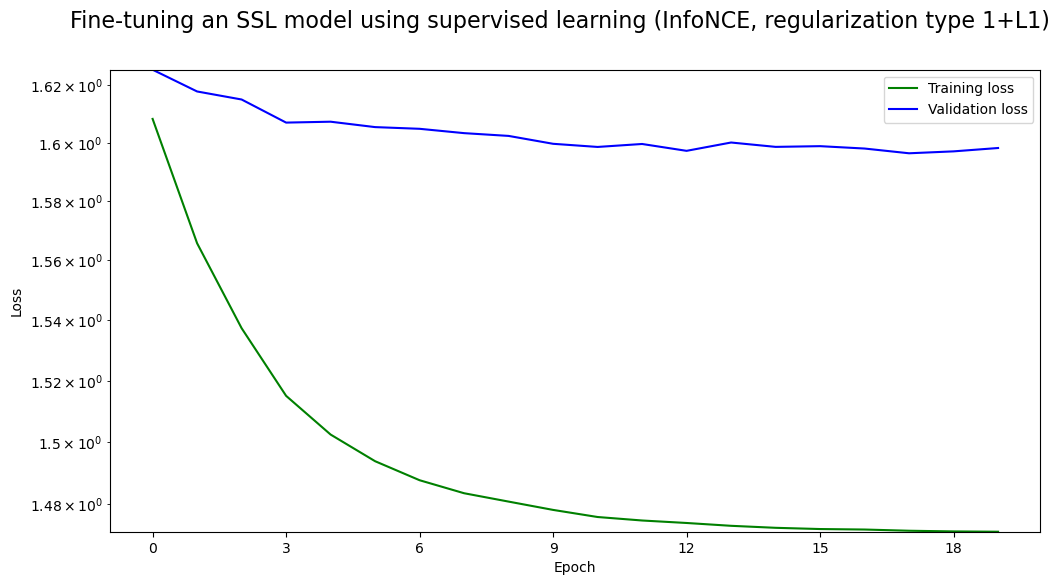

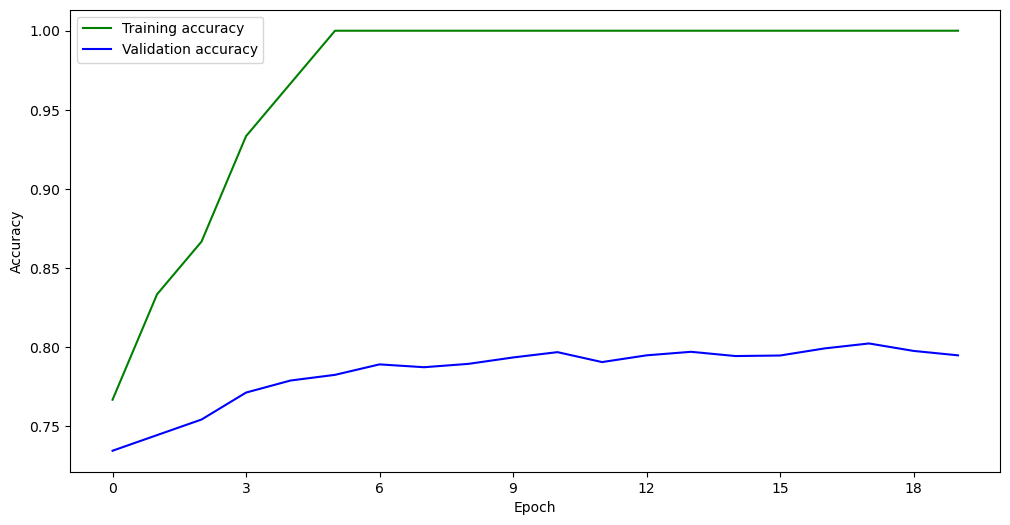

  0%|          | 0/20 [00:00<?, ?it/s]

Best downstream task accuracy: 0.845200


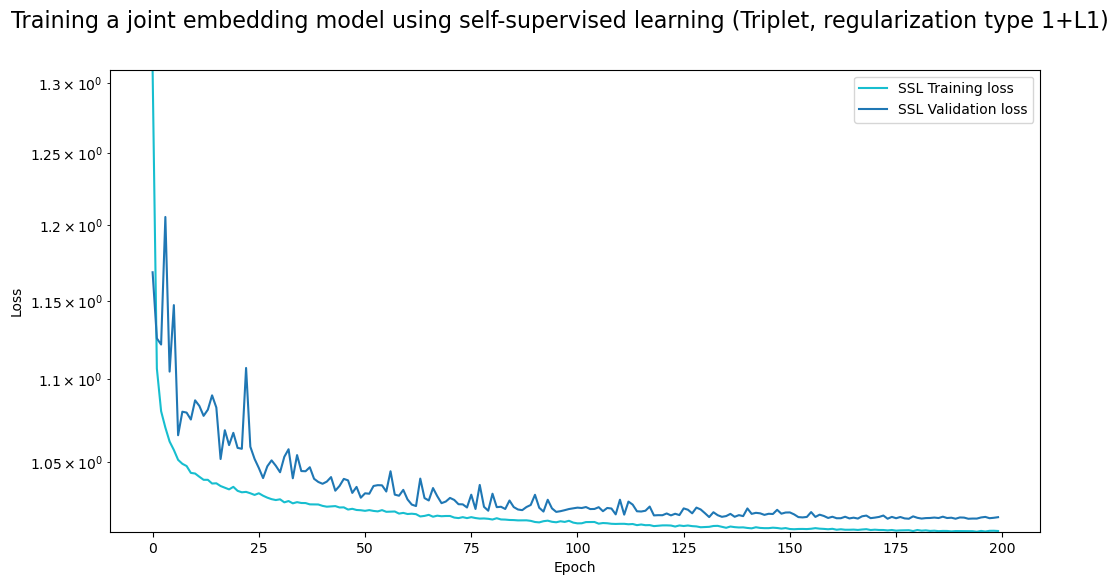

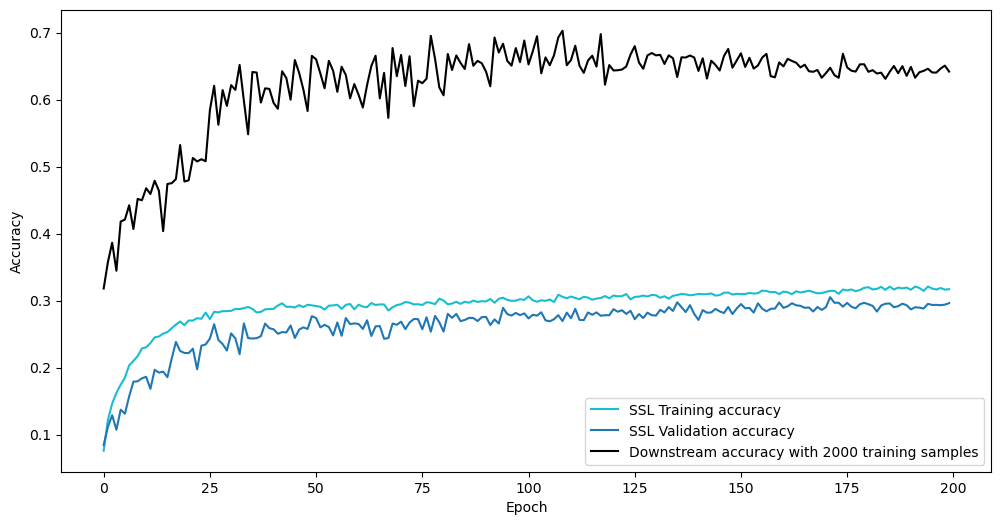

  0%|          | 0/200 [00:00<?, ?it/s]

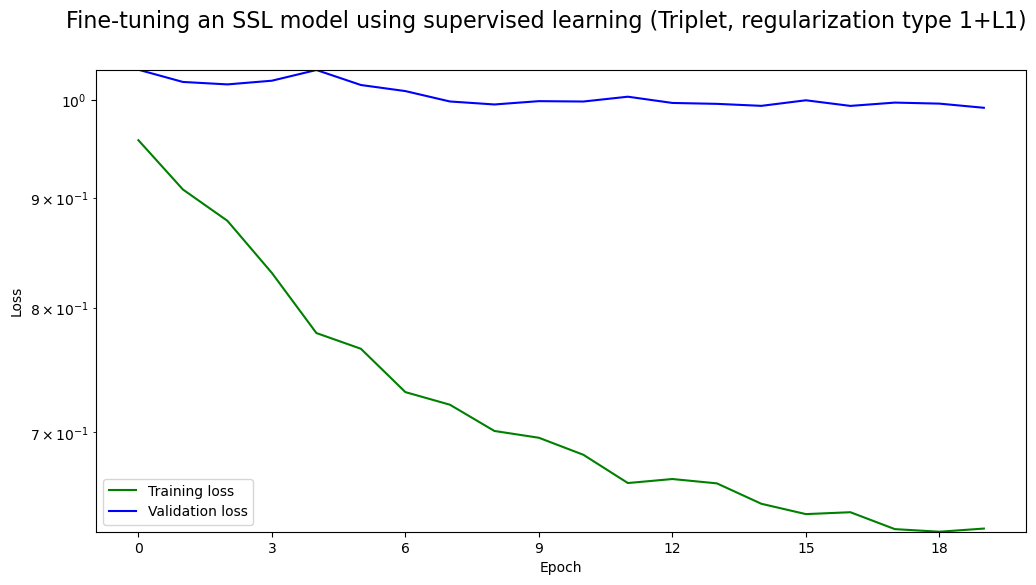

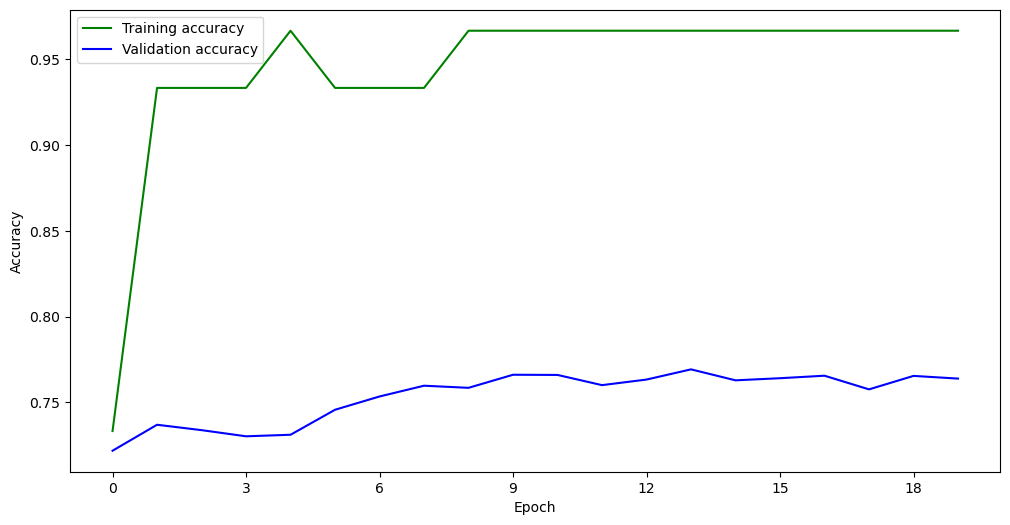

  0%|          | 0/20 [00:00<?, ?it/s]

Best downstream task accuracy: 0.702700


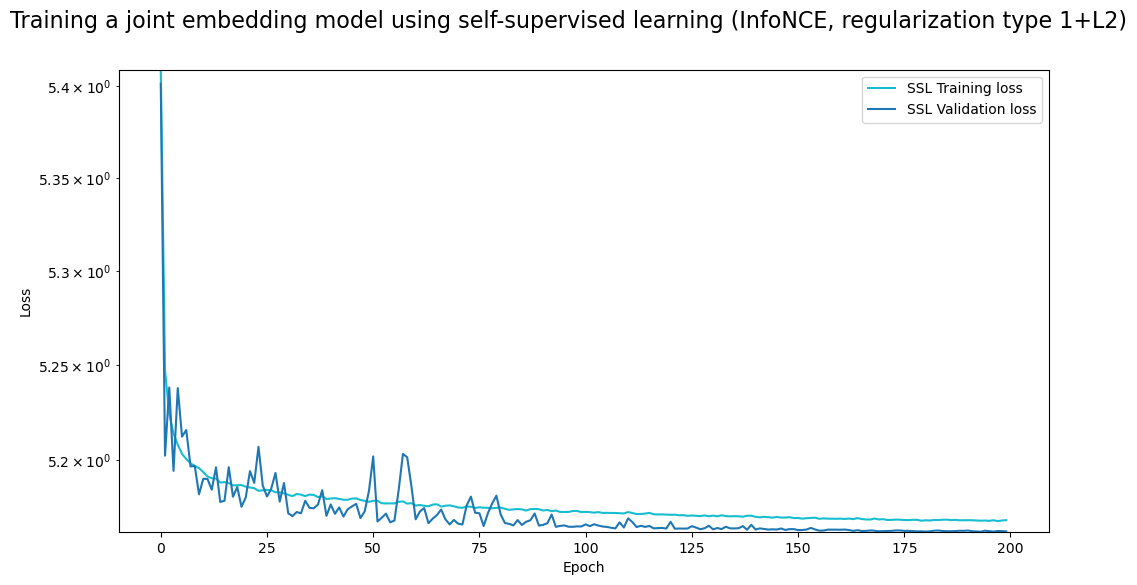

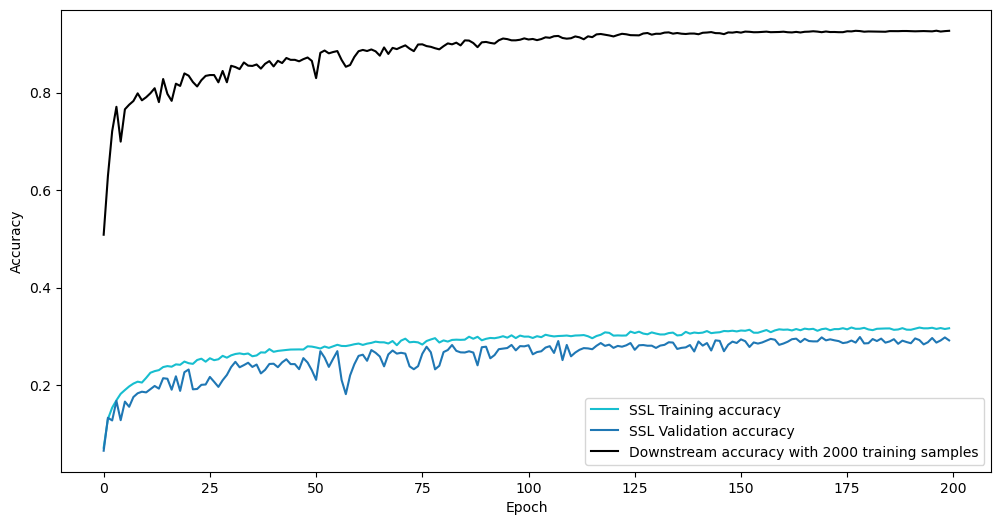

  0%|          | 0/200 [00:00<?, ?it/s]

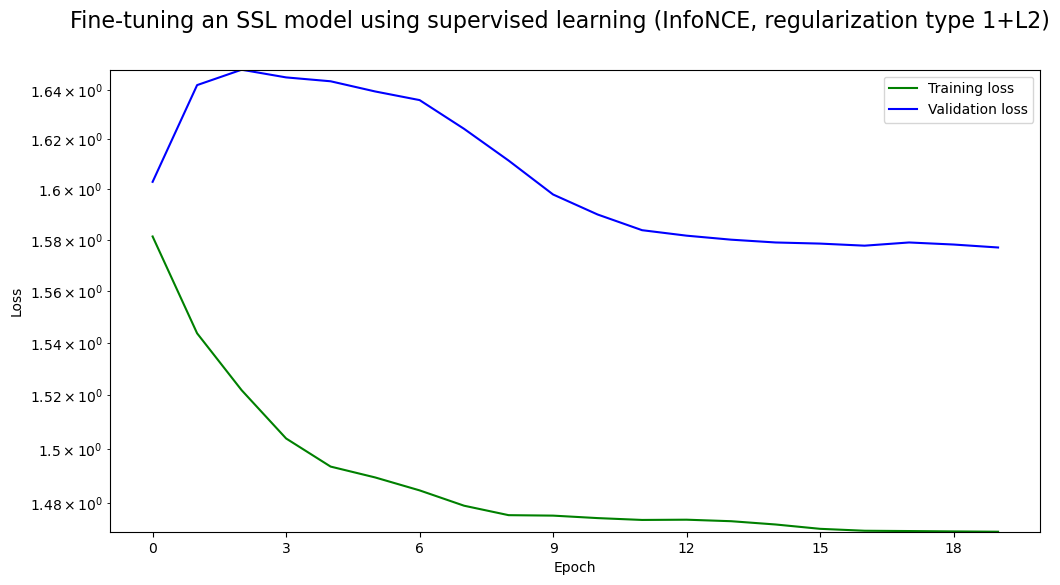

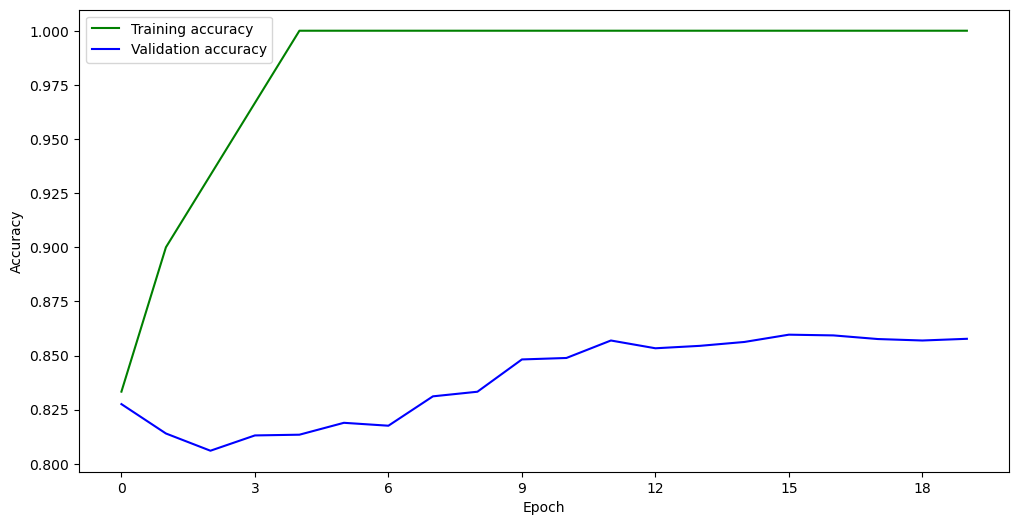

  0%|          | 0/20 [00:00<?, ?it/s]

Best downstream task accuracy: 0.926700


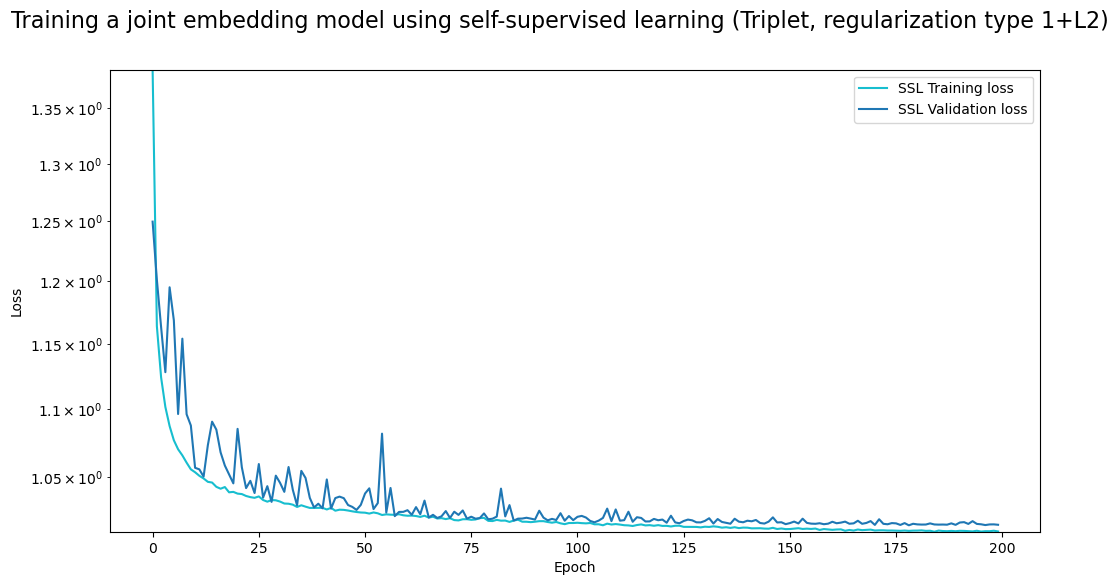

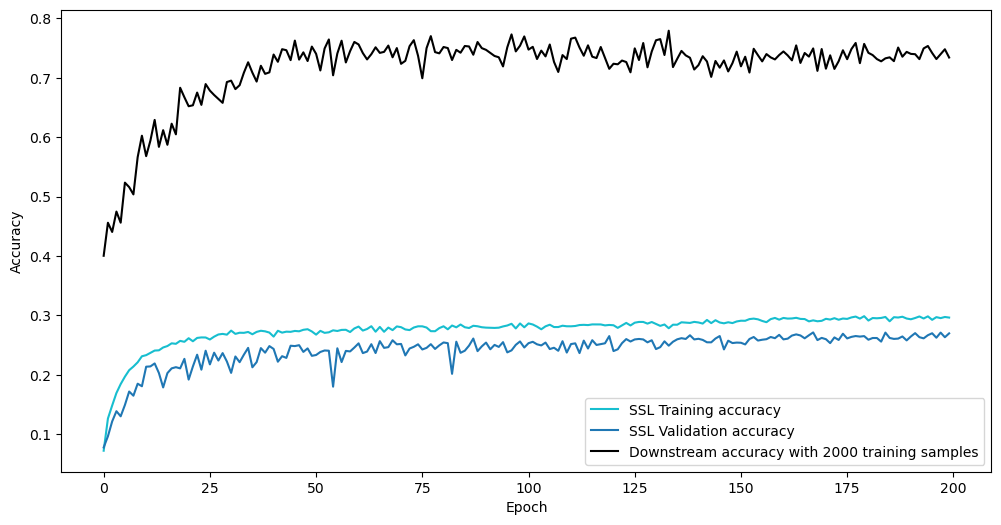

  0%|          | 0/200 [00:00<?, ?it/s]

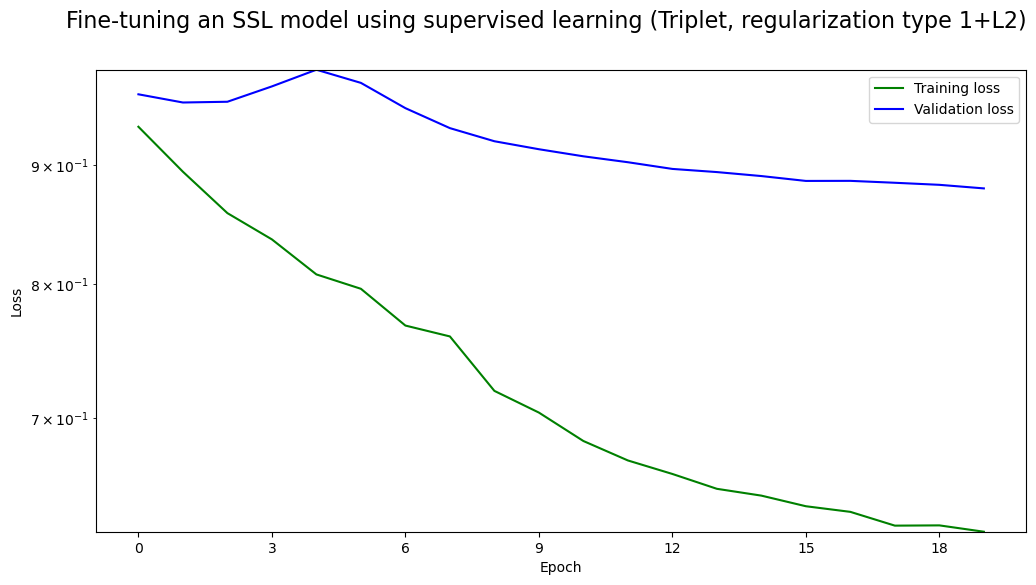

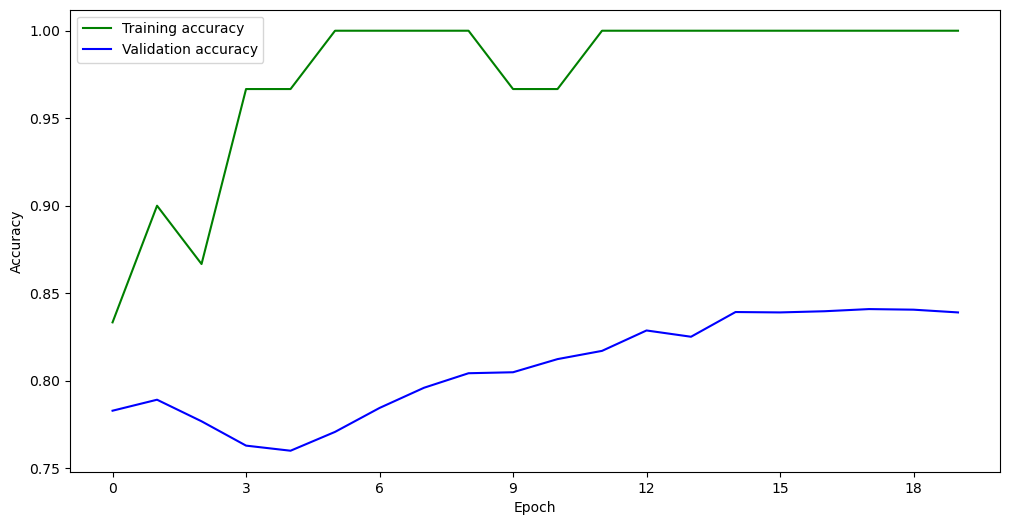

  0%|          | 0/20 [00:00<?, ?it/s]

Best downstream task accuracy: 0.779300


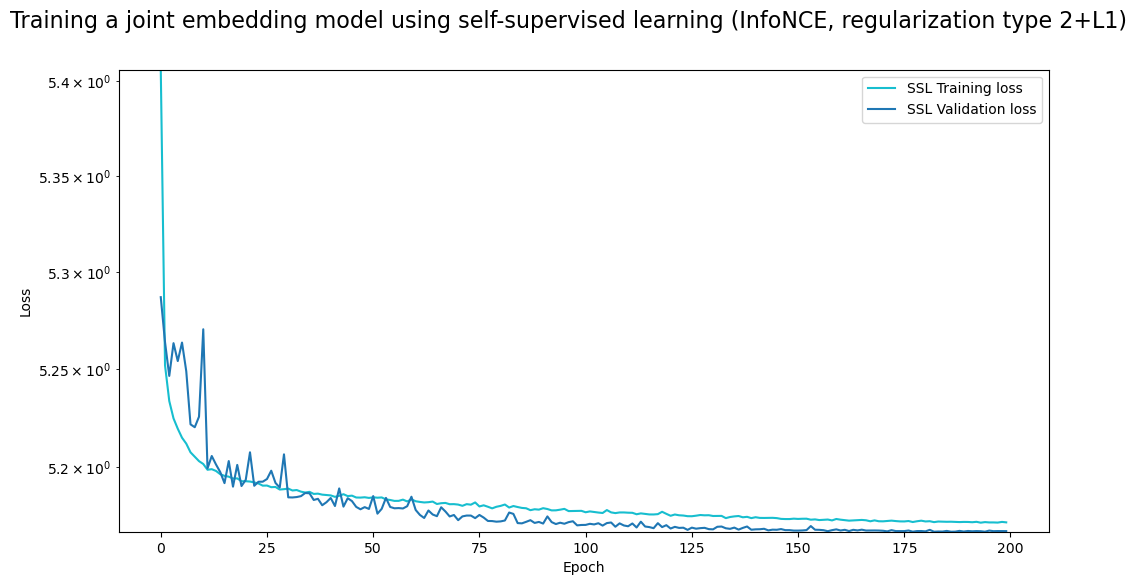

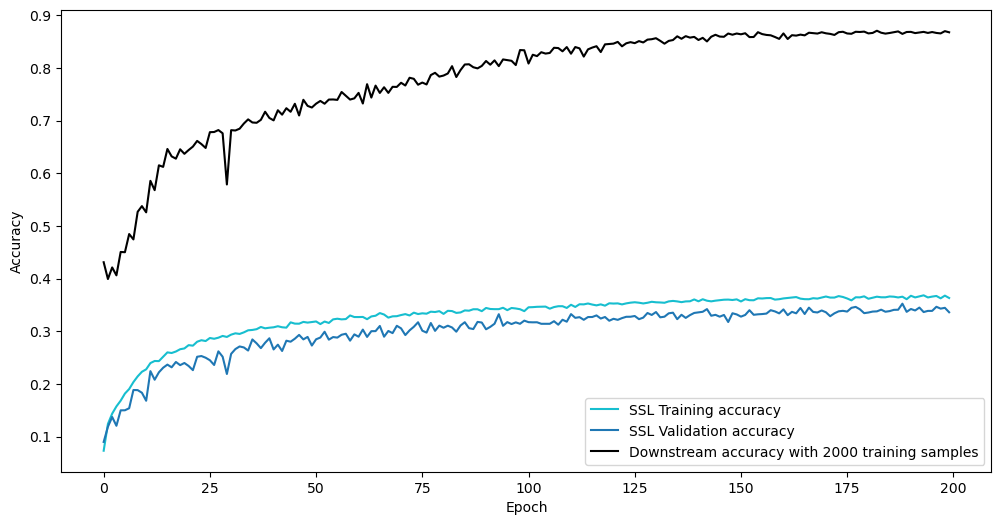

  0%|          | 0/200 [00:00<?, ?it/s]

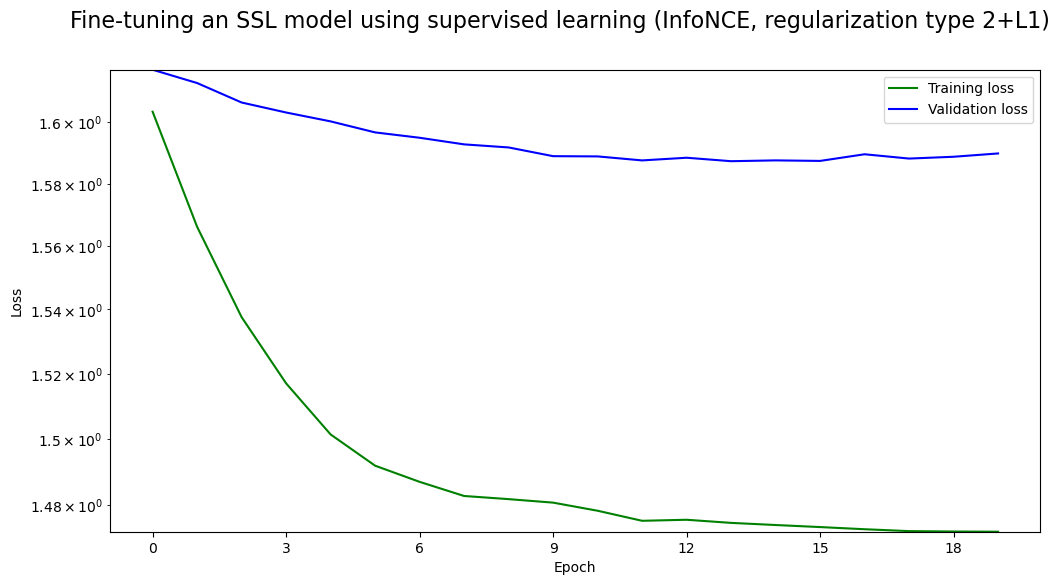

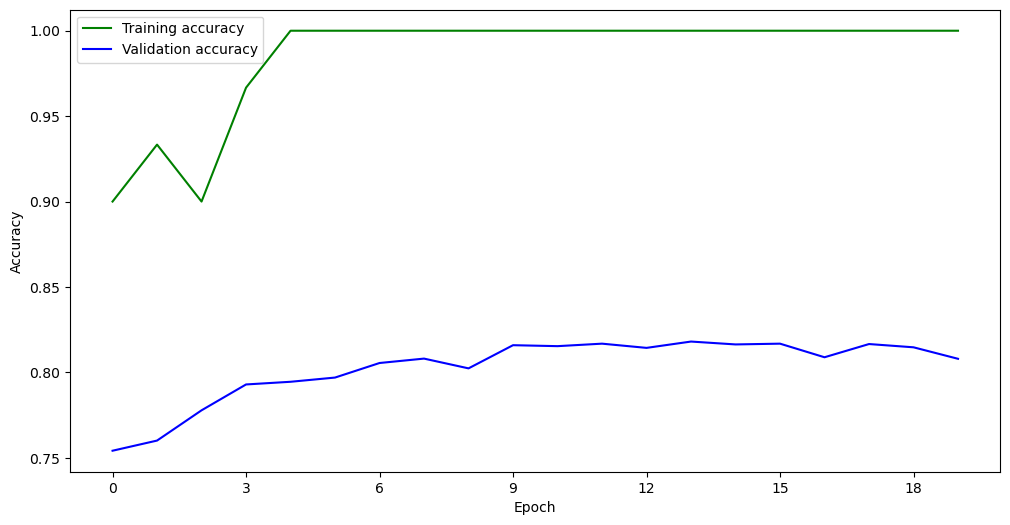

  0%|          | 0/20 [00:00<?, ?it/s]

Best downstream task accuracy: 0.870600


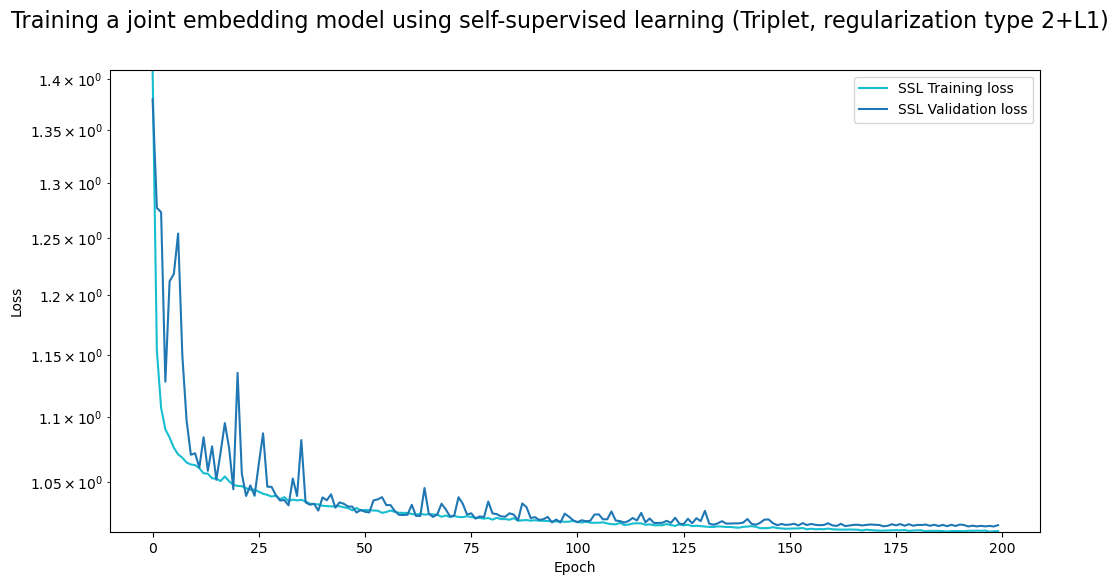

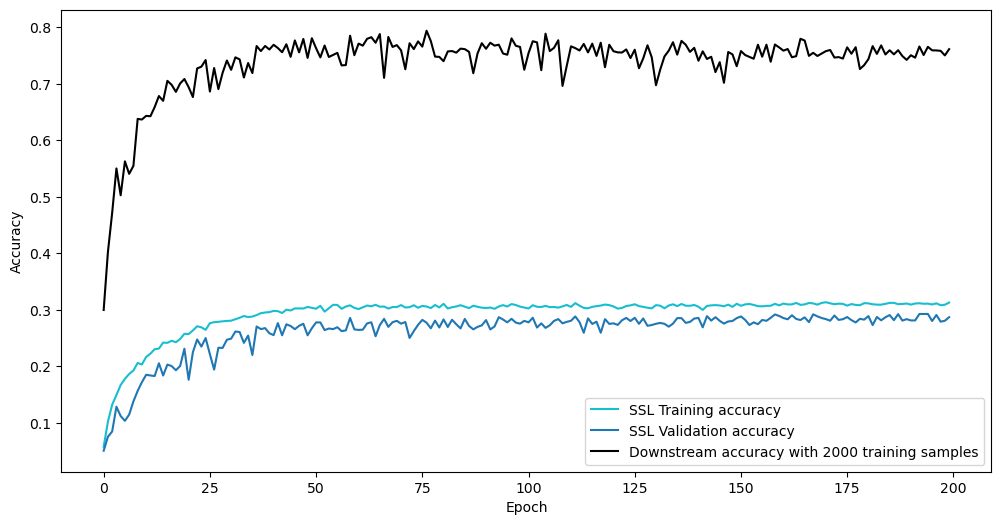

  0%|          | 0/200 [00:00<?, ?it/s]

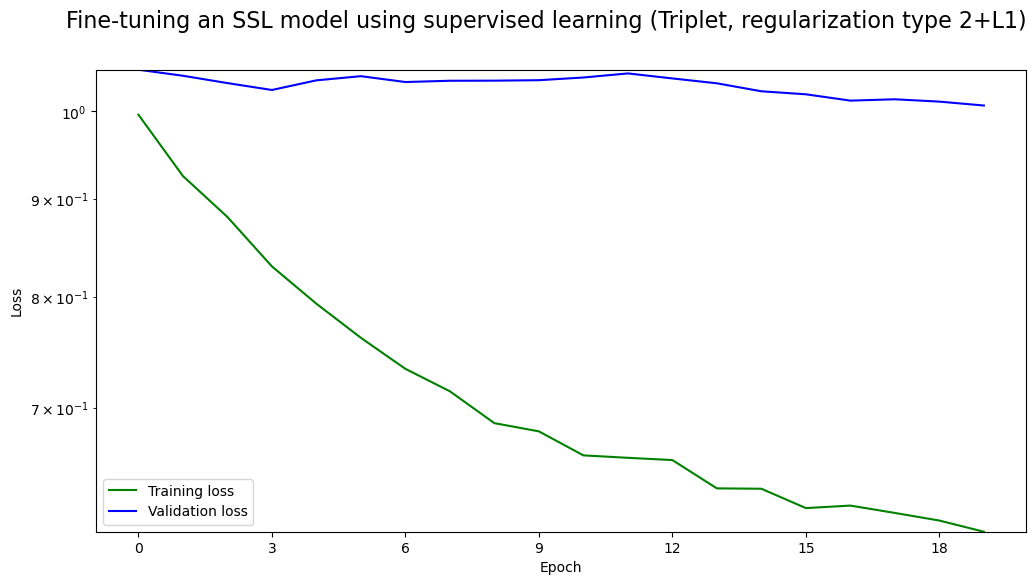

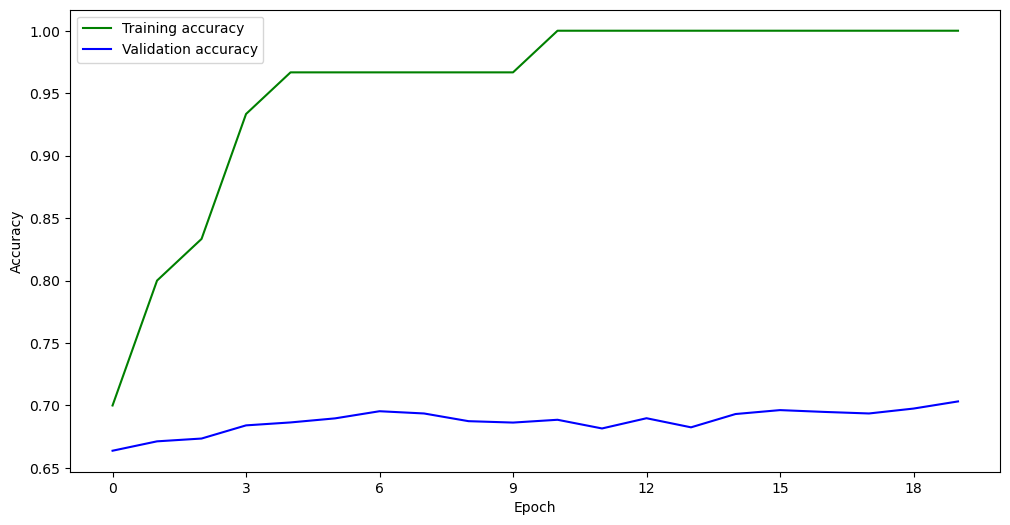

  0%|          | 0/20 [00:00<?, ?it/s]

Best downstream task accuracy: 0.794100


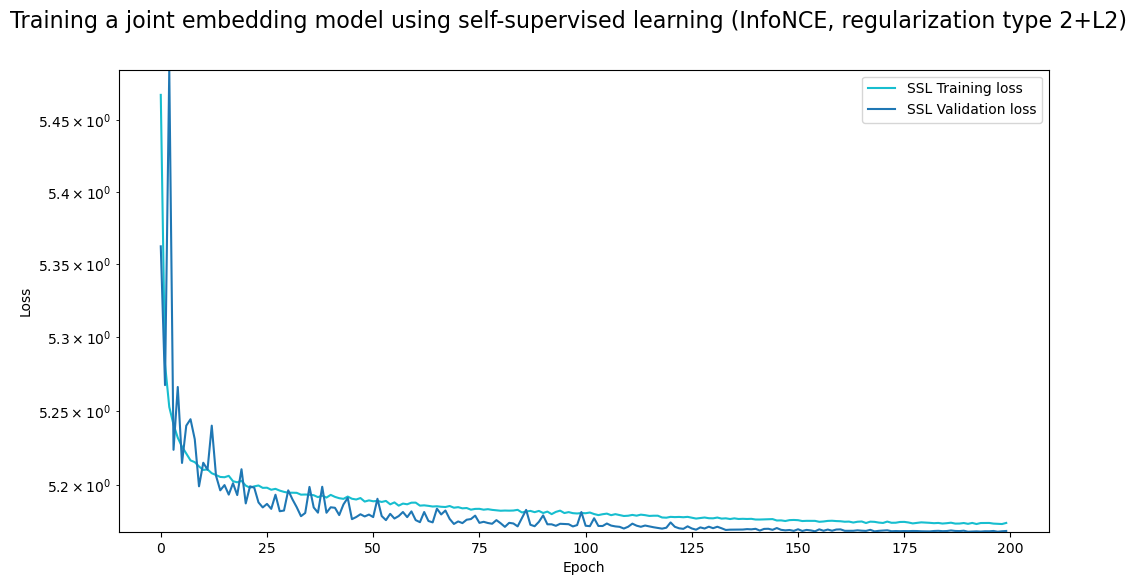

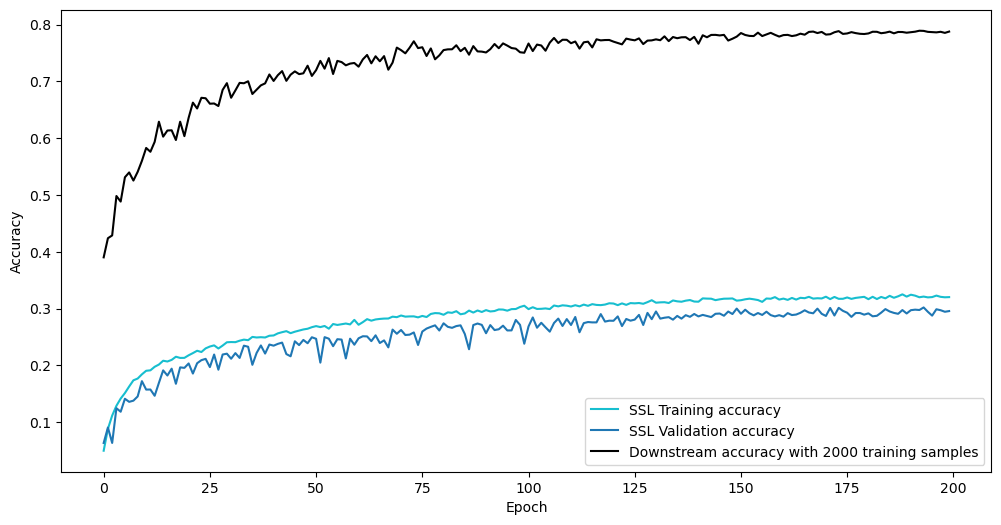

  0%|          | 0/200 [00:00<?, ?it/s]

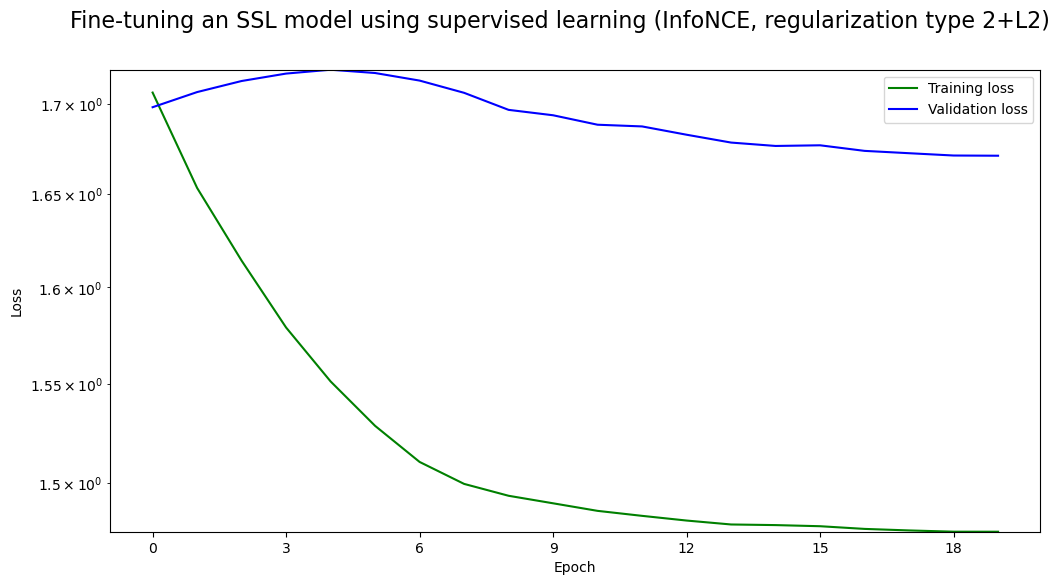

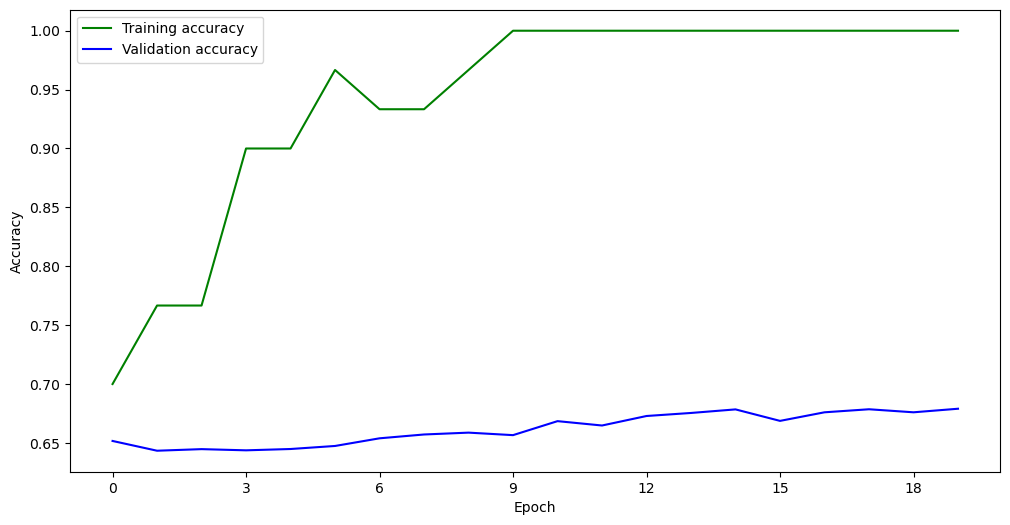

  0%|          | 0/20 [00:00<?, ?it/s]

Best downstream task accuracy: 0.789300


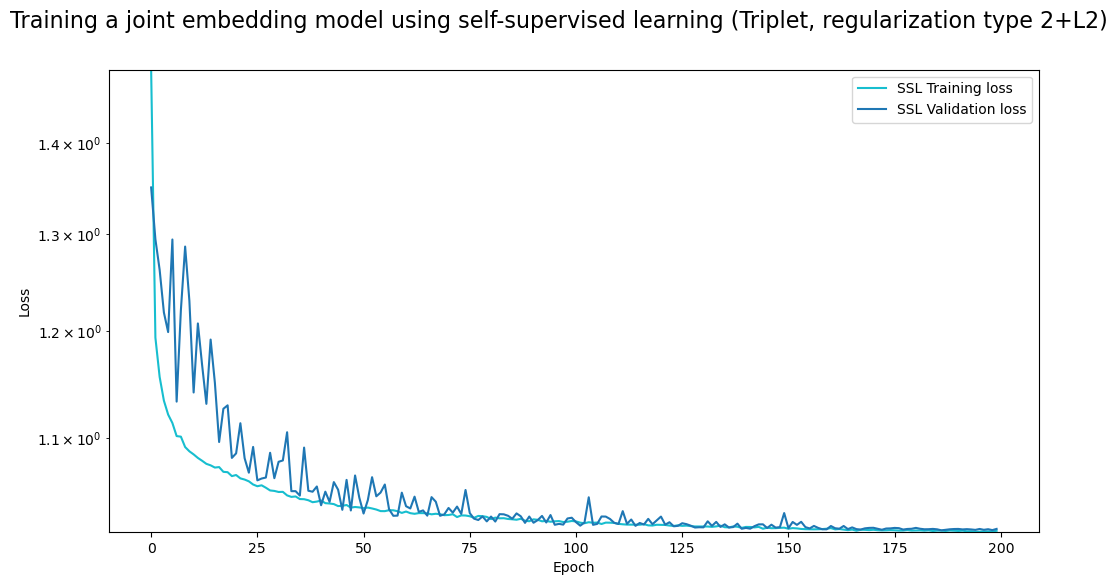

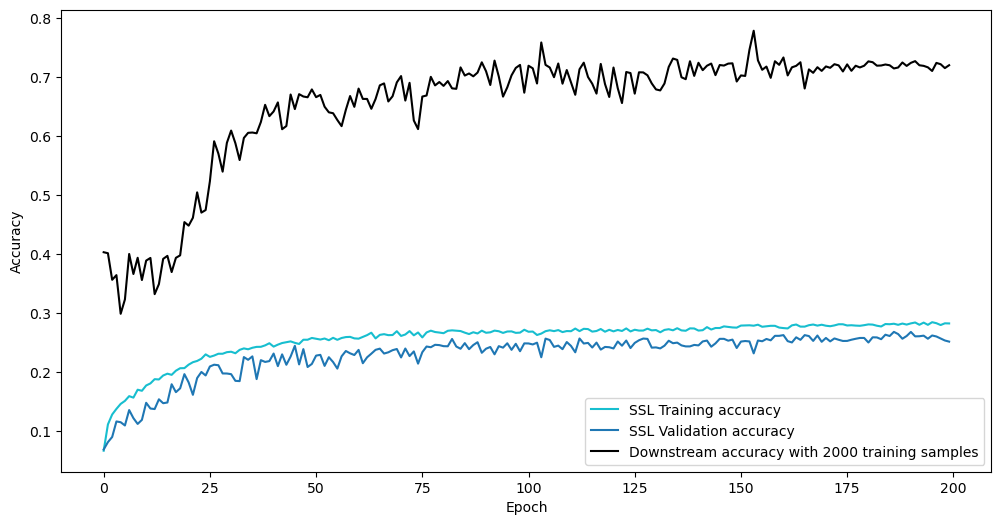

  0%|          | 0/200 [00:00<?, ?it/s]

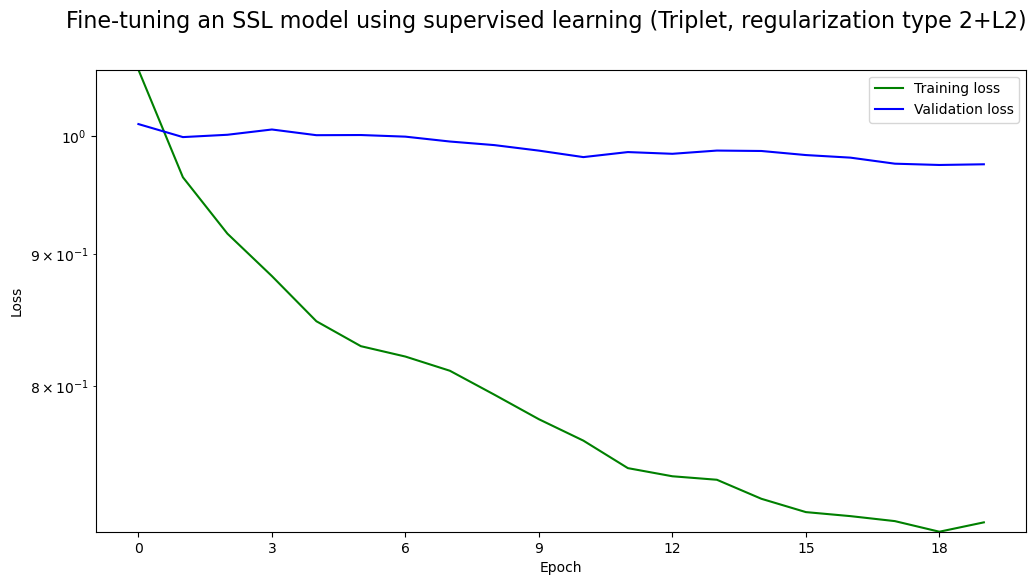

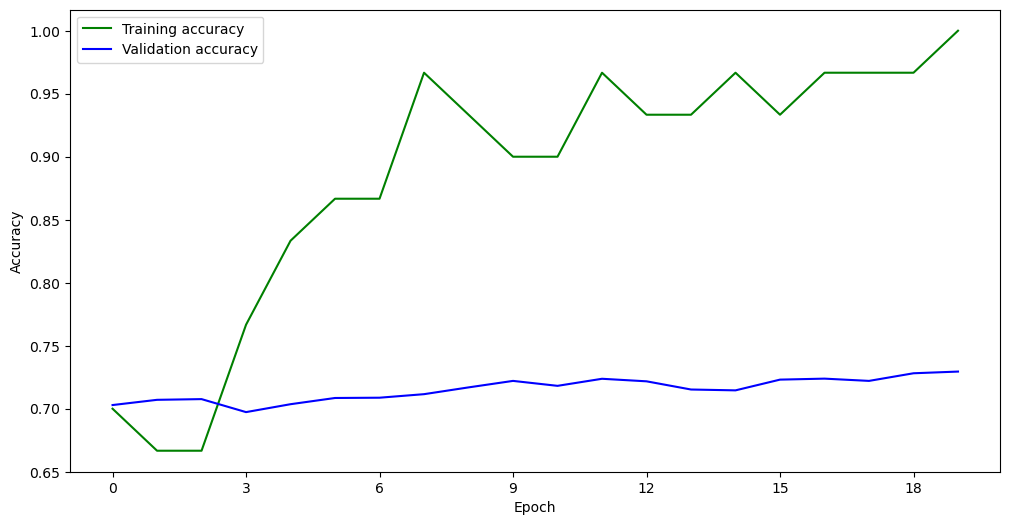

  0%|          | 0/20 [00:00<?, ?it/s]

Best downstream task accuracy: 0.778600
{'acc': 0.9267, 'tower': MnistCnn(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (projector): Sequential(
    (0): Linear(in_features=2048, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
), 'config': {'regularization': <function norm_regularization_1_l2 at 0x7f39bfd4b490>, 'loss_function': <function info_nce_loss a

In [25]:
champion_ssl = {
    "acc": 0,
    "tower": None,
    "config": None,
}

regularizations = (no_regularization, norm_regularization_1_l1, norm_regularization_1_l2, norm_regularization_2_l1, norm_regularization_2_l2)
loss_functions = (info_nce_loss, triplet_loss)

configs = list(itertools.product(regularizations, loss_functions))

for (reg, loss_fn) in tqdm_notebook(configs):
    plot_title_ssl = f"Training a joint embedding model using self-supervised learning ({plottitle_loss[loss_fn]}, {plottitle_reg[reg]})"
    html_title_ssl = f"self-supervised joint embedding model trained with {plottitle_loss[loss_fn]} loss function and {plottitle_reg[reg]}"
    plot_title_sl = f"Fine-tuning an SSL model using supervised learning ({plottitle_loss[loss_fn]}, {plottitle_reg[reg]})"
    html_title_sl = f"self-supervised joint embedding model fine-tuned with SL (50 samples), {plottitle_loss[loss_fn]} loss function and {plottitle_reg[reg]}"
    
    model = MnistCnn(latent_size).to(device)
    best_tower, best_acc, plot_data = jem_ssl(model, loss_fn, reg, finetune_with_sl=False,
                                              plot_title=plot_title_ssl,
                                              epochs=200, silent=False, downstream_epochs=10, downstream_sample_count=2000)
    export_plotly_html(plot_data, f"ssl_charts/{filename_loss[loss_fn]}_{filename_reg[reg]}.html", html_title_ssl)

    model_copy = MnistCnn(latent_size).to(device)
    model_copy.load_state_dict(best_tower.state_dict())
    _, _, plot_data = jem_sl(model_copy, loss_fn, reg, plot_title=plot_title_sl,
                             epochs=20, silent=False, training_sample_count=50, lr_multiplier=0.2)
    export_plotly_html(plot_data, f"ssl_sl_charts/{filename_loss[loss_fn]}_{filename_reg[reg]}.html", html_title_sl)
    
    print(f"Best downstream task accuracy: {best_acc:3f}")
    if champion_ssl["acc"] < best_acc:
        champion_ssl["acc"] = best_acc
        champion_ssl["tower"] = best_tower
        champion_ssl["config"] = {
            "regularization": reg,
            "loss_function": loss_fn,
        }

torch.save(champion_ssl["tower"], "./champion_tower_ssl.pt")
print(champion_ssl)

In [26]:
# champion_ssl = {
#     "acc": 0,
#     "tower": torch.load("./champion_tower_ssl.pt"),
#     "config": {
#         "regularization": no_regularization,
#         "loss_function": info_nce_loss,
#     },
# }

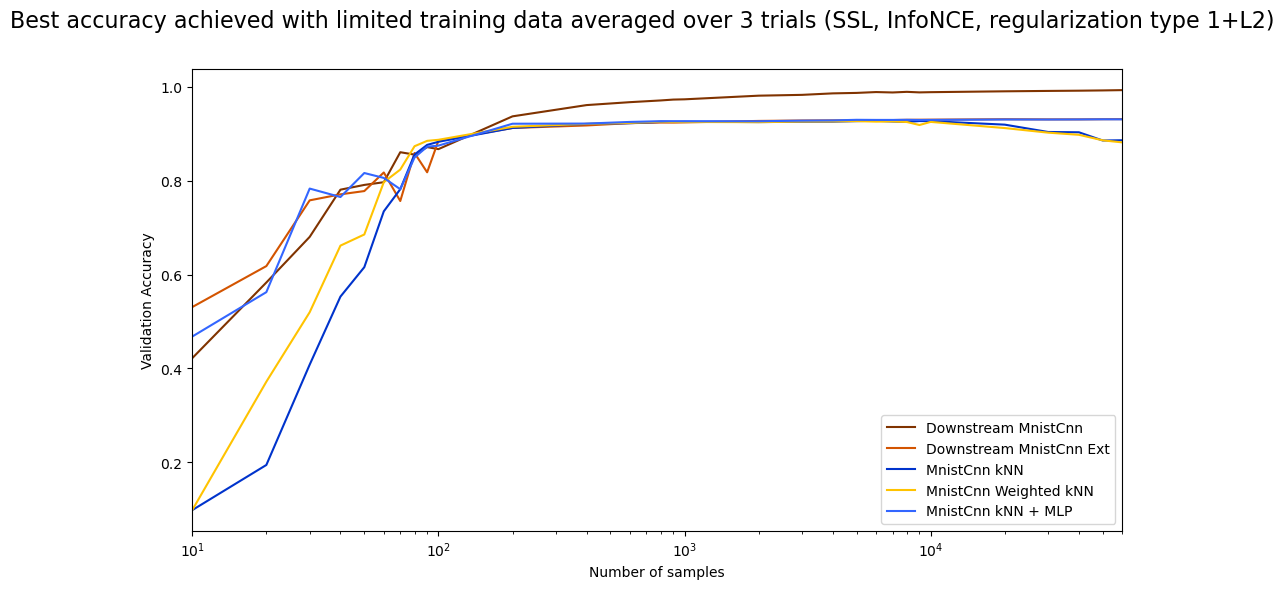

  0%|          | 0/30 [00:00<?, ?it/s]

'<table>\n<tbody>\n<tr><td>                             </td><td>10                   </td><td>20                   </td><td>30                    </td><td>40                   </td><td>50                    </td><td>60                    </td><td>70                    </td><td>80                   </td><td>90                   </td><td>100                  </td><td>200                   </td><td>400                   </td><td>600                  </td><td>800                   </td><td>900                  </td><td>1000                  </td><td>2000                 </td><td>3000                  </td><td>4000                  </td><td>5000                  </td><td>6000                  </td><td>7000                  </td><td>8000                  </td><td>9000                  </td><td>10000                 </td><td>20000                 </td><td>30000                 </td><td>40000                </td><td>50000                 </td><td>60000                 </td></tr>\n<tr><td>Downstream MnistCnn Avg      </td><td>0.4219333333333333   </td><td>0.5832333333333333   </td><td>0.6804666666666667    </td><td>0.7811               </td><td>0.7912333333333333    </td><td>0.797                 </td><td>0.8609333333333332    </td><td>0.8558333333333333   </td><td>0.8718333333333333   </td><td>0.8675               </td><td>0.9374000000000001    </td><td>0.9613999999999999    </td><td>0.9676333333333332   </td><td>0.9712999999999999    </td><td>0.9731333333333333   </td><td>0.9737                </td><td>0.9814666666666666   </td><td>0.9832                </td><td>0.9863666666666666    </td><td>0.9873666666666666    </td><td>0.9891666666666666    </td><td>0.9883000000000001    </td><td>0.9896333333333334    </td><td>0.9884666666666666    </td><td>0.9889333333333333    </td><td>0.9907666666666667    </td><td>0.9916                </td><td>0.9921000000000001   </td><td>0.9926666666666667    </td><td>0.9933                </td></tr>\n<tr><td>Downstream MnistCnn Ext Avg  </td><td>0.5308666666666667   </td><td>0.6182               </td><td>0.7583333333333334    </td><td>0.7711333333333333   </td><td>0.7781333333333333    </td><td>0.8177666666666666    </td><td>0.7569                </td><td>0.8592333333333334   </td><td>0.8181333333333334   </td><td>0.8852666666666668   </td><td>0.9126333333333333    </td><td>0.9179999999999998    </td><td>0.9229333333333333   </td><td>0.9242                </td><td>0.9241333333333334   </td><td>0.9245333333333333    </td><td>0.9276333333333332   </td><td>0.9285                </td><td>0.9288333333333333    </td><td>0.9290333333333333    </td><td>0.9294333333333333    </td><td>0.9294666666666668    </td><td>0.9300333333333333    </td><td>0.9302                </td><td>0.9303333333333333    </td><td>0.9312666666666667    </td><td>0.9309333333333334    </td><td>0.9309666666666666   </td><td>0.9313333333333333    </td><td>0.9315333333333333    </td></tr>\n<tr><td>MnistCnn kNN Avg             </td><td>0.09800000000000002  </td><td>0.19426666666666667  </td><td>0.4081666666666666    </td><td>0.5531666666666667   </td><td>0.6158666666666667    </td><td>0.7349                </td><td>0.7821000000000001    </td><td>0.8560333333333334   </td><td>0.8765333333333333   </td><td>0.8831666666666665   </td><td>0.9126333333333333    </td><td>0.9212666666666666    </td><td>0.9228               </td><td>0.9255333333333334    </td><td>0.9254333333333333   </td><td>0.9260666666666667    </td><td>0.9251666666666667   </td><td>0.9258333333333333    </td><td>0.926                 </td><td>0.9272333333333332    </td><td>0.9279999999999999    </td><td>0.9264                </td><td>0.9254000000000001    </td><td>0.9273999999999999    </td><td>0.9271333333333334    </td><td>0.9197000000000001    </td><td>0.9040666666666667    </td><td>0.9034333333333334   </td><td>0.8859                </td><td>0.8864333333333333    </td></tr>\n<tr><td>MnistCnn Weighted kNN Avg    </td><td>0.09800000000000002  </td><td>0.37176666666666663  </td><td

In [29]:
data_point_x = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 400, 600, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000]
averages = {
    "Downstream MnistCnn": [],
    "Downstream MnistCnn Ext": [],
    "MnistCnn kNN": [],
    "MnistCnn Weighted kNN": [],
    "MnistCnn kNN + MLP": [],
}
st_deviations = {
    "Downstream MnistCnn": [],
    "Downstream MnistCnn Ext": [],
    "MnistCnn kNN": [],
    "MnistCnn Weighted kNN": [],
    "MnistCnn kNN + MLP": [],
}
model_epochs = {
    "Downstream MnistCnn": 200,
    "Downstream MnistCnn Ext": 200,
    "MnistCnn kNN": 10,
    "MnistCnn Weighted kNN": 10,
    "MnistCnn kNN + MLP": 200,
}

plot_progress = Plots(charts={"Downstream MnistCnn": "#803300",
                              "Downstream MnistCnn Ext": "#d35400",
                              "MnistCnn kNN": "#0033cc",
                              "MnistCnn Weighted kNN": "#FFC300",
                              "MnistCnn kNN + MLP": "#3366ff"},
                      title=f"Best accuracy achieved with limited training data averaged over 3 trials (SSL, {plottitle_loss[champion_ssl['config']['loss_function']]}, {plottitle_reg[champion_ssl['config']['regularization']]})",
                      log_x=True, x_axis_title="Number of samples", y_axis_title="Validation Accuracy")

ds_models = {
    "Downstream MnistCnn": lambda upstream, loader: DownstreamMnistCnn(upstream, output_size=10, device=device),
    "Downstream MnistCnn Ext": lambda upstream, loader: DownstreamMnistCnnExt(upstream, latent_size=latent_size,
                                                                              output_size=10, device=device),
    "MnistCnn kNN": lambda upstream, loader: MnistCnnkNN(upstream, loader, neighbourhood_size=10, device=device),
    "MnistCnn Weighted kNN": lambda upstream, loader: MnistCnnWeightedkNN(upstream, loader, neighbourhood_size=10, device=device),
    "MnistCnn kNN + MLP": lambda upstream, loader: MnistCnnkNNMlp(upstream, loader,
                                                                        neighbourhood_size=10, latent_size=latent_size,
                                                                        output_size=10, device=device),
}

for training_sample_count in tqdm_notebook(data_point_x):
    labeled_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(mnist_data[:training_sample_count], mnist_targets[:training_sample_count]),
        shuffle=True,
        batch_size=training_sample_count,
        num_workers=16,
        prefetch_factor=2,
    )
    for model_name, model_instantiator in ds_models.items():
        sum_acc = 0
        sq_sum_acc = 0
        for i in range(3):
            best_acc = classification(model_instantiator(champion_ssl["tower"], labeled_loader), epochs=model_epochs[model_name], training_sample_count=training_sample_count, lr_multiplier=1)
            sum_acc += best_acc
            sq_sum_acc += best_acc * best_acc
        avg_acc = sum_acc / 3
        std_acc = math.sqrt(max(0, sq_sum_acc / 3 - avg_acc * avg_acc))
        plot_progress.add_point(model_name, training_sample_count, avg_acc)
        plot_progress.plot()
        averages[model_name].append(avg_acc)
        st_deviations[model_name].append(std_acc)
plot_progress.close()

tabulate.tabulate([[""] + data_point_x,
                   ["Downstream MnistCnn Avg"] + averages["Downstream MnistCnn"],
                   ["Downstream MnistCnn Ext Avg"] + averages["Downstream MnistCnn Ext"],
                   ["MnistCnn kNN Avg"] + averages["MnistCnn kNN"],
                   ["MnistCnn Weighted kNN Avg"] + averages["MnistCnn Weighted kNN"],
                   ["MnistCnn kNN + MLP Avg"] + averages["MnistCnn kNN + MLP"],
                   ["" for _ in range(len(data_point_x)+1)],
                   ["Downstream MnistCnn Stdev"] + st_deviations["Downstream MnistCnn"],
                   ["Downstream MnistCnn Ext Stdev"] + st_deviations["Downstream MnistCnn Ext"],
                   ["MnistCnn kNN Stdev"] + st_deviations["MnistCnn kNN"],
                   ["MnistCnn Weighted kNN Stdev"] + st_deviations["MnistCnn Weighted kNN"],
                   ["MnistCnn kNN + MLP Stdev"] + st_deviations["MnistCnn kNN + MLP"],
                  ], tablefmt='html')

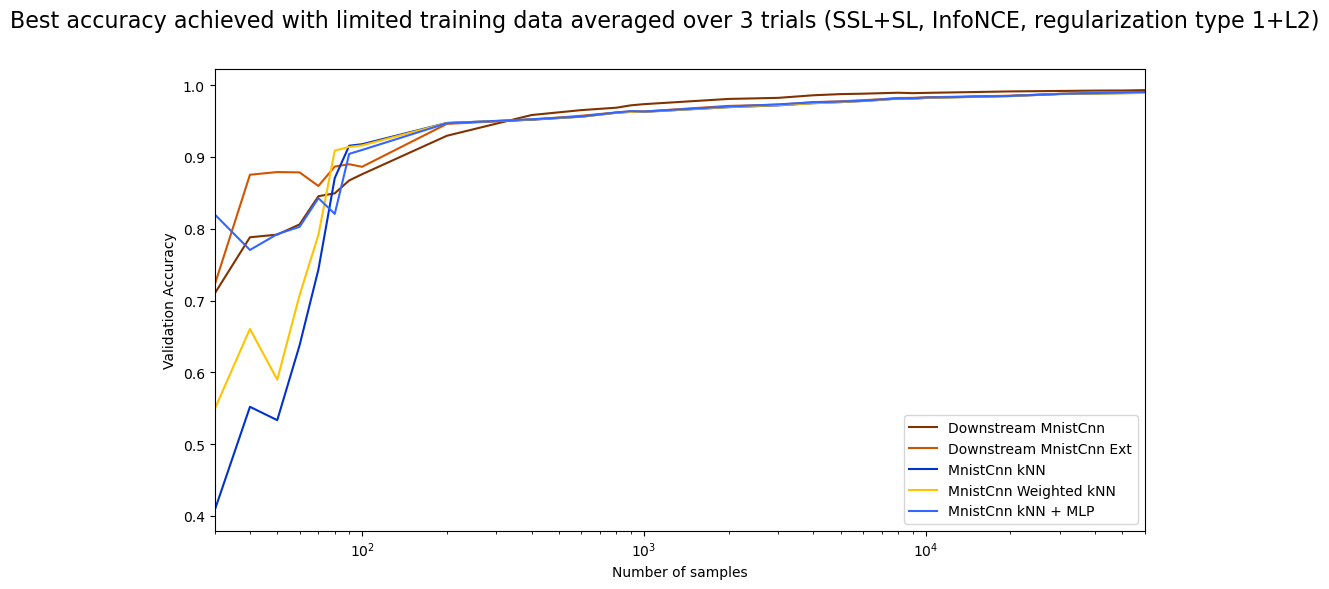

  0%|          | 0/28 [00:00<?, ?it/s]

'<table>\n<tbody>\n<tr><td>                             </td><td>30                    </td><td>40                   </td><td>50                    </td><td>60                    </td><td>70                   </td><td>80                    </td><td>90                   </td><td>100                  </td><td>200                   </td><td>400                   </td><td>600                   </td><td>800                   </td><td>900                  </td><td>1000                 </td><td>2000                  </td><td>3000                  </td><td>4000                  </td><td>5000                  </td><td>6000                  </td><td>7000                  </td><td>8000                  </td><td>9000                  </td><td>10000                 </td><td>20000                 </td><td>30000                 </td><td>40000                 </td><td>50000                 </td><td>60000                 </td></tr>\n<tr><td>Downstream MnistCnn Avg      </td><td>0.7099333333333334    </td><td>0.7881666666666667   </td><td>0.7918666666666666    </td><td>0.8061000000000001    </td><td>0.8453666666666667   </td><td>0.8493666666666666    </td><td>0.8673333333333334   </td><td>0.8759666666666667   </td><td>0.9295333333333332    </td><td>0.9584333333333334    </td><td>0.9652666666666666    </td><td>0.9686333333333333    </td><td>0.9719333333333333   </td><td>0.9735333333333333   </td><td>0.9808333333333333    </td><td>0.9823333333333334    </td><td>0.9859333333333332    </td><td>0.9875666666666666    </td><td>0.9881333333333333    </td><td>0.9888666666666667    </td><td>0.9894666666666666    </td><td>0.9888666666666666    </td><td>0.9892666666666666    </td><td>0.9913                </td><td>0.9919333333333333    </td><td>0.9924333333333334    </td><td>0.9925666666666667    </td><td>0.9931                </td></tr>\n<tr><td>Downstream MnistCnn Ext Avg  </td><td>0.7222                </td><td>0.8752666666666666   </td><td>0.879                 </td><td>0.8785333333333334    </td><td>0.8596333333333334   </td><td>0.8866666666666667    </td><td>0.8899333333333334   </td><td>0.8863333333333333   </td><td>0.9460999999999999    </td><td>0.9521000000000001    </td><td>0.9573666666666667    </td><td>0.9620000000000001    </td><td>0.9633666666666668   </td><td>0.9633333333333333   </td><td>0.9711333333333333    </td><td>0.9727333333333333    </td><td>0.9764                </td><td>0.9774666666666668    </td><td>0.9790666666666666    </td><td>0.9805                </td><td>0.9821333333333332    </td><td>0.9823000000000001    </td><td>0.9830666666666666    </td><td>0.9853333333333333    </td><td>0.9880333333333334    </td><td>0.9890666666666666    </td><td>0.9897333333333332    </td><td>0.9902666666666665    </td></tr>\n<tr><td>MnistCnn kNN Avg             </td><td>0.40820000000000006   </td><td>0.5520666666666667   </td><td>0.5335                </td><td>0.6376                </td><td>0.7433666666666667   </td><td>0.8706999999999999    </td><td>0.9156333333333334   </td><td>0.9177333333333334   </td><td>0.9474                </td><td>0.9518666666666666    </td><td>0.9561333333333334    </td><td>0.9616000000000001    </td><td>0.9628333333333333   </td><td>0.9628333333333333   </td><td>0.9693666666666667    </td><td>0.9718666666666667    </td><td>0.9749333333333333    </td><td>0.9764333333333334    </td><td>0.9779666666666667    </td><td>0.9796333333333335    </td><td>0.9813                </td><td>0.9811                </td><td>0.9822666666666667    </td><td>0.9849333333333333    </td><td>0.9876333333333335    </td><td>0.9882                </td><td>0.9889666666666667    </td><td>0.9892333333333333    </td></tr>\n<tr><td>MnistCnn Weighted kNN Avg    </td><td>0.5489666666666667    </td><td>0.6606               </td><td>0.5898333333333333    </td><td>0.7074666666666666    </td><td>0.7915666666666666   </td><td>0.9089                </td><td>0.914                </td><td>0.9161333333333334   </td><td>0.9471666666666666    </td><td>0.9523          

In [32]:
data_point_x = [30, 40, 50, 60, 70, 80, 90, 100, 200, 400, 600, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000]
averages = {
    "Downstream MnistCnn": [],
    "Downstream MnistCnn Ext": [],
    "MnistCnn kNN": [],
    "MnistCnn Weighted kNN": [],
    "MnistCnn kNN + MLP": [],
}
st_deviations = {
    "Downstream MnistCnn": [],
    "Downstream MnistCnn Ext": [],
    "MnistCnn kNN": [],
    "MnistCnn Weighted kNN": [],
    "MnistCnn kNN + MLP": [],
}
model_epochs = {
    "Downstream MnistCnn": 200,
    "Downstream MnistCnn Ext": 200,
    "MnistCnn kNN": 10,
    "MnistCnn Weighted kNN": 10,
    "MnistCnn kNN + MLP": 200,
}

plot_progress = Plots(charts={"Downstream MnistCnn": "#803300",
                              "Downstream MnistCnn Ext": "#d35400",
                              "MnistCnn kNN": "#0033cc",
                              "MnistCnn Weighted kNN": "#FFC300",
                              "MnistCnn kNN + MLP": "#3366ff"},
                      title=f"Best accuracy achieved with limited training data averaged over 3 trials (SSL+SL, {plottitle_loss[champion_ssl['config']['loss_function']]}, {plottitle_reg[champion_ssl['config']['regularization']]})",
                      log_x=True, x_axis_title="Number of samples", y_axis_title="Validation Accuracy")

ds_models = {
    "Downstream MnistCnn": lambda upstream, loader: DownstreamMnistCnn(upstream, output_size=10, device=device),
    "Downstream MnistCnn Ext": lambda upstream, loader: DownstreamMnistCnnExt(upstream, latent_size=latent_size,
                                                                              output_size=10, device=device),
    "MnistCnn kNN": lambda upstream, loader: MnistCnnkNN(upstream, loader,
                                                         neighbourhood_size=10, device=device),
    "MnistCnn Weighted kNN": lambda upstream, loader: MnistCnnWeightedkNN(upstream, loader, neighbourhood_size=10, device=device),
    "MnistCnn kNN + MLP": lambda upstream, loader: MnistCnnkNNMlp(upstream, loader,
                                                                  neighbourhood_size=10, latent_size=latent_size,
                                                                  output_size=10, device=device),
}

for training_sample_count in tqdm_notebook(data_point_x):
    labeled_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(mnist_data[:training_sample_count], mnist_targets[:training_sample_count]),
        shuffle=True,
        batch_size=training_sample_count,
        num_workers=16,
        prefetch_factor=2,
    )
    upstream_model = MnistCnn(latent_size).to(device)
    upstream_model.load_state_dict(champion_ssl["tower"].state_dict())
    upstream_model, _ = jem_sl(upstream_model, champion_ssl['config']['loss_function'], champion_ssl['config']['regularization'],
                               epochs=200, silent=True, training_sample_count=training_sample_count)
    for model_name, model_instantiator in ds_models.items():
        sum_acc = 0
        sq_sum_acc = 0
        for i in range(3):
            downstream_model = model_instantiator(upstream_model, labeled_loader)
            best_acc = classification(downstream_model, epochs=model_epochs[model_name], training_sample_count=training_sample_count, lr_multiplier=1)
            sum_acc += best_acc
            sq_sum_acc += best_acc * best_acc
        avg_acc = sum_acc / 3
        std_acc = math.sqrt(max(0, sq_sum_acc / 3 - avg_acc * avg_acc))
        plot_progress.add_point(model_name, training_sample_count, avg_acc)
        plot_progress.plot()
        averages[model_name].append(avg_acc)
        st_deviations[model_name].append(std_acc)
plot_progress.close()

tabulate.tabulate([[""] + data_point_x,
                   ["Downstream MnistCnn Avg"] + averages["Downstream MnistCnn"],
                   ["Downstream MnistCnn Ext Avg"] + averages["Downstream MnistCnn Ext"],
                   ["MnistCnn kNN Avg"] + averages["MnistCnn kNN"],
                   ["MnistCnn Weighted kNN Avg"] + averages["MnistCnn Weighted kNN"],
                   ["MnistCnn kNN + MLP Avg"] + averages["MnistCnn kNN + MLP"],
                   ["" for _ in range(len(data_point_x)+1)],
                   ["Downstream MnistCnn Stdev"] + st_deviations["Downstream MnistCnn"],
                   ["Downstream MnistCnn Ext Stdev"] + st_deviations["Downstream MnistCnn Ext"],
                   ["MnistCnn kNN Stdev"] + st_deviations["MnistCnn kNN"],
                   ["MnistCnn Weighted kNN Stdev"] + st_deviations["MnistCnn Weighted kNN"],
                   ["MnistCnn kNN + MLP Stdev"] + st_deviations["MnistCnn kNN + MLP"],
                  ], tablefmt='html')